C:\Users\jc2713\AppData\Local\Temp\ipykernel_6200\3787197481.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


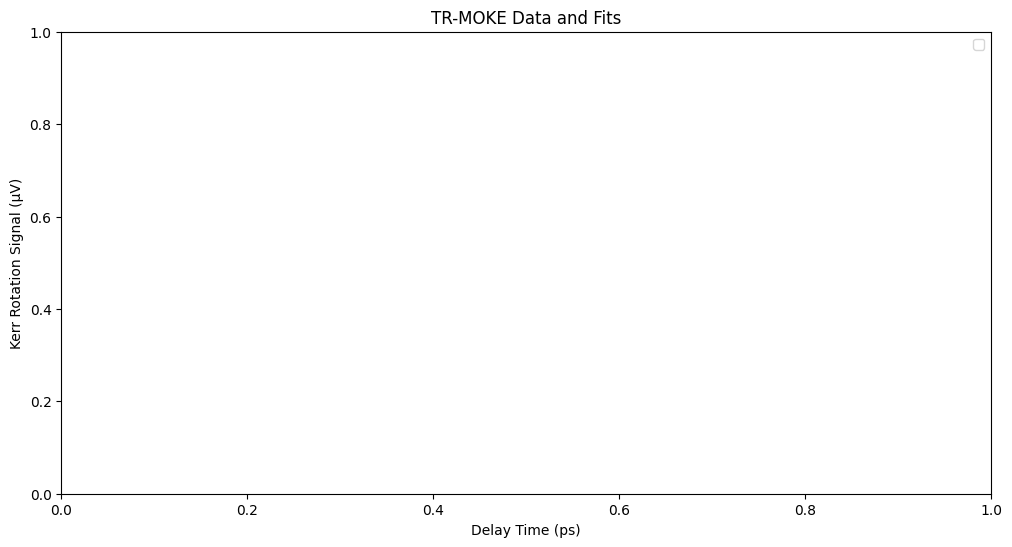

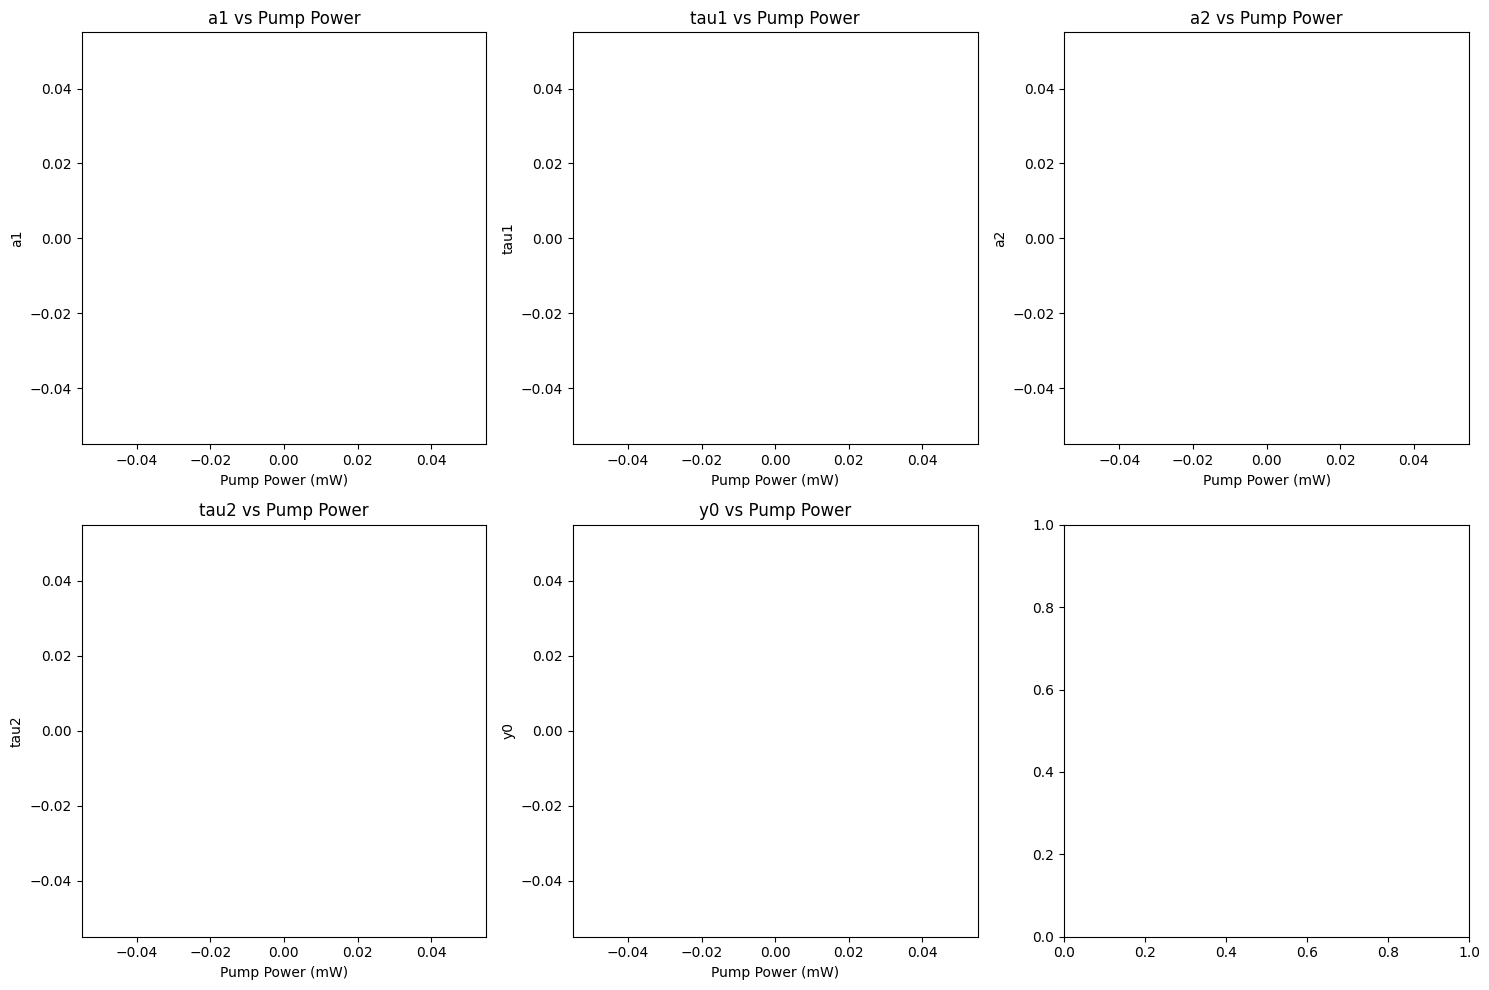

In [2]:
#45 mV ??? why is the magnetisation value to high. Divide by pi

import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import glob
import os
import re

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        # Read header
        header = f.readline()
        pump_power = float(re.search(r'Pump power \(mW\) = "(\d+\.\d+)"', header).group(1))
        
        # Skip the column headers
        f.readline()
        
        # Read data
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, data

def double_exponential(x, a1, tau1, a2, tau2, y0):
    return a1 * np.exp(-x / tau1) + a2 * np.exp(-x / tau2) + y0

# Get all data files
data_files = glob.glob('*.txt')  # Adjust the pattern if needed

plt.figure(figsize=(12, 6))

pump_powers = []
fit_params = []

cutoff = 0

for file in data_files:
    pump_power, data = read_tr_moke_data(file)
    pump_powers.append(pump_power)
    
    delay_time = data[:, 1]
    kerr_rotation = data[:, 2]
    
    # Plot raw data
    plt.plot(delay_time, kerr_rotation, 'o', label=f'Data ({pump_power} mW)')
    
    # Fit double exponential
    model = Model(double_exponential)
    params = model.make_params(a1=1, tau1=1, a2=1, tau2=10, y0=0)
    result = model.fit(kerr_rotation, params, x=delay_time)
    
    # Plot fit
    plt.plot(delay_time, result.best_fit, '-', label=f'Fit ({pump_power} mW)')
    
    fit_params.append(result.best_values)

plt.xlabel('Delay Time (ps)')
plt.ylabel('Kerr Rotation Signal (μV)')
plt.legend()
plt.title('TR-MOKE Data and Fits')
plt.show()

# Plot fit parameters as a function of pump power
param_names = ['a1', 'tau1', 'a2', 'tau2', 'y0']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, param in enumerate(param_names):
    values = [params[param] for params in fit_params]
    axes[i].plot(pump_powers, values, 'o-')
    axes[i].set_xlabel('Pump Power (mW)')
    axes[i].set_ylabel(param)
    axes[i].set_title(f'{param} vs Pump Power')

plt.tight_layout()
plt.show()


Header: "Field strength (mT) = ",6.13555972603737,", Pump power (mW) = ","2.08",", Add number = ",1," Original stage position =",25,", Field ID = ",0,", Expected field (mT) = ",24.2245919,", HWP angle (probe) = ",1.14779,", HWP angle (pump) = ",191.624,", QWP angle (pump) = ",0,", reflectance = ",0
Extracted pump power: 2.08 mW
[ 0.06671282  0.13342564  0.20013846  0.26685128  0.3335641   0.40027691
  0.46698973  0.53370255  0.60041537  0.66712819  0.73384101  0.80055383
  1.13411792  1.46768202  1.80124611  2.13481021  2.4683743   2.8019384
  3.13550249  3.46906659  3.80263069  4.13619478  4.46975888  4.80332297
  5.13688707  5.47045116  5.80401526  6.13757935  6.47114345  6.80470754
  7.13827164  7.47183573  7.80539983  8.13896392  8.47252802  8.80609211
  9.13965621  9.4732203   9.8067844  10.14034849 10.47391259 10.80747668
 11.14104078 11.47460487 11.80816897 12.14173307 12.47529716 12.80886126
 13.14242535]


ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

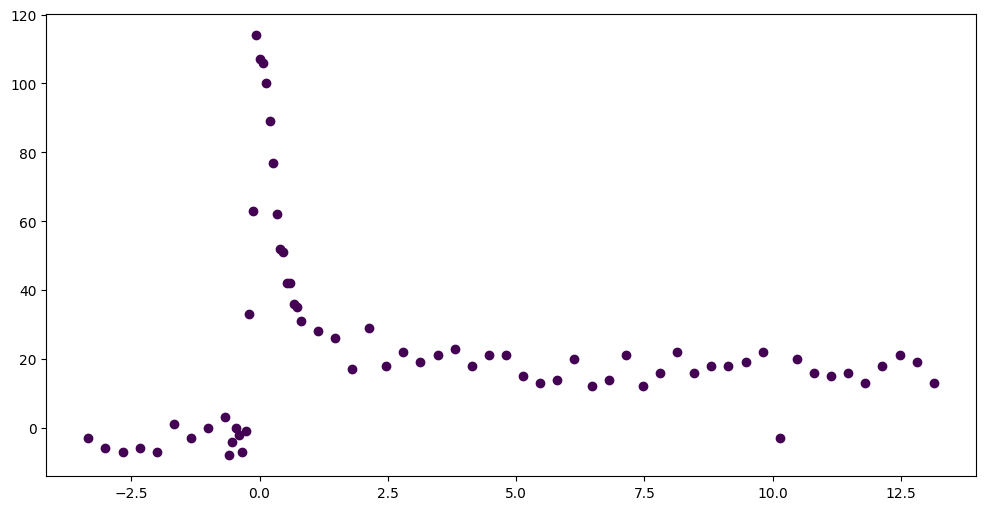

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import os
import re
from matplotlib.cm import viridis

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        # Read header
        header = f.readline().strip()
        print("Header:", header)
        
        # Updated regular expression to match the actual format
        match = re.search(r'Pump power \(mW\) = ","(\d+\.?\d*)"', header)
        if match:
            pump_power = float(match.group(1))
            print(f"Extracted pump power: {pump_power} mW")
        else:
            print("Pump power not found in header")
            pump_power = None
        
        # Skip the column headers
        f.readline()
        
        # Read data
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, data

def double_exponential(x, a1, tau1,x1, a2, tau2,x2, y0):
    return a1 * np.exp(-(x-x1) / tau1) + a2 * np.exp(-(x-x2) / tau2) + y0

def single_exponential(x, a1, tau1, y0):
    return a1 * np.exp(-x / tau1) + y0

# Specify the folder containing the data files
data_folder = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-6mT-Powersweep'  # Replace with your actual folder path

plt.figure(figsize=(12, 6))

pump_powers = []
fit_params = []
from natsort import natsorted

# Get all files in the data folder
data_files = os.listdir(data_folder)

# Sort the files using natural sorting
data_file_sort = natsorted(data_files)

# Filter for .txt files
data_files_filter = [file for file in data_file_sort if file.endswith('.txt')]

fit_data = True
cmap = viridis
colors = cmap(np.linspace(0, 1, len(data_files_filter)))

for file, color in zip(data_files_filter, colors):
    file_path = os.path.join(data_folder, file)
    pump_power, data = read_tr_moke_data(file_path)
    pump_powers.append(pump_power)
    
    delay_time = data[:, 0]
    kerr_rotation = data[:, 1]
    
    # Plot raw data
    plt.plot(delay_time, kerr_rotation, 'o', label=f'Data ({pump_power} mW)',color = color)
    if fit_data:
        # Filter data for fitting (time > 0 ps)
        fit_mask = delay_time > 0.05
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = kerr_rotation[fit_mask]
        print(fit_delay_time)
        
        # Fit double exponential
        model = Model(double_exponential)
        params = model.make_params()
        params.add('a1', value=1, min=0, max=100)
        params.add('a2', value=1, min=0, max=100)
        params.add('x1', value=1, min=0.1, max=5)
        params.add('x2', value=3, min=0.1, max=10)
        params.add('tau1', value=1, min=1, max=1000)
        params.add('tau2', value=1, min=1, max=1000)
        result = model.fit(fit_kerr_rotation, params, x=fit_delay_time)
        print(result.best_values)
        
        # Plot fit
        plt.plot(fit_delay_time, result.best_fit, '-', label=f'Fit ({pump_power} mW)',color = color)
        
        fit_params.append(result.best_values)

plt.xlabel('Delay Time (ps)')
plt.ylabel('Kerr Rotation Signal (μV)')
plt.legend()
plt.title('TR-MOKE Data and Fits (t > 0 ps)')
plt.show()

if fit_data:

    # Plot fit parameters as a function of pump power
    param_names = ['a1', 'tau1','x1', 'a2', 'tau2','x2', 'y0']
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, param in enumerate(param_names):
        values = [params[param] for params in fit_params]
        axes[i].plot(pump_powers, values, 'o-')
        axes[i].set_xlabel('Pump Power (mW)')
        axes[i].set_ylabel(param)
        axes[i].set_title(f'{param} vs Pump Power')

plt.tight_layout()
plt.show()


In [4]:
def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        # Read header
        header = f.readline().strip()
        print("Header:", header)
        
        # Extract pump power
        pump_power_match = re.search(r'Pump power \(mW\) = ","(\d+\.?\d*)"', header)
        if pump_power_match:
            pump_power = float(pump_power_match.group(1))
            print(f"Extracted pump power: {pump_power} mW")
        else:
            print("Pump power not found in header")
            pump_power = None
        
        # Extract field strength
        field_strength_match = re.search(r'Field strength \(mT\) = ","([-+]?\d*\.?\d+)"', header)
        if field_strength_match:
            field_strength = float(field_strength_match.group(1))
            print(f"Extracted field strength: {field_strength} mT")
        else:
            print("Field strength not found in header")
            field_strength = None
        
        # Skip the column headers
        f.readline()
        
        # Read data
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, field_strength, data



C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
Header: "Field strength (mT) = ",509.163431440973,", Pump power (mW) = ","2.12",", Add number = ",1," Original stage position =",25,", Field ID = ",500,", Expected field (mT) = ",550.179555664775,", HWP angle (probe) = ",1.14779,", HWP angle (pump) = ",191.64348,", QWP angle (pump) = ",0,", reflectance = ",0
Extracted field strength: 509.163431440973 mT
Extracted pump power: 2.12 mW
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
Header: "Field strength (mT) = ",509.163431440973,", Pump power (mW) = ","12.0",", Add number = ",1," Original stage position =",25,", Field ID = ",500,", Expected field (mT) = ",550.179555664775,", HWP angle (probe) = ",1.14779,", HWP angle (pump) = ",196.091836,", QWP angle (pu

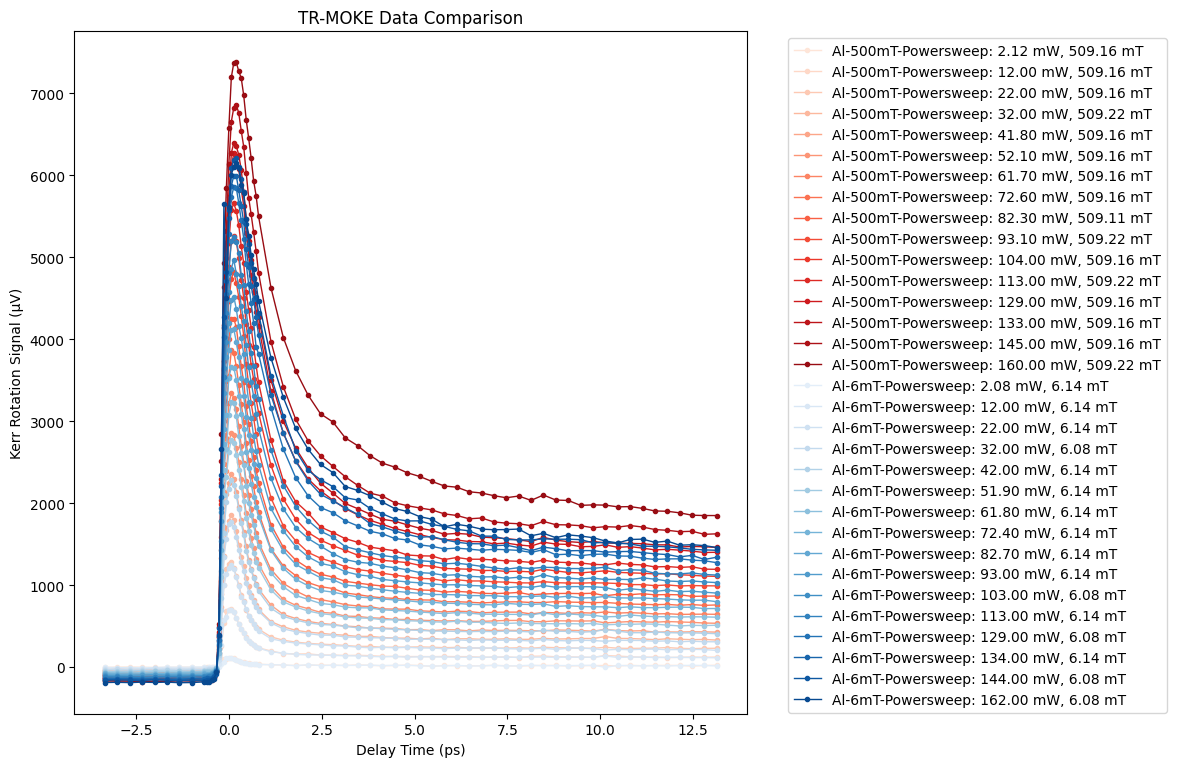

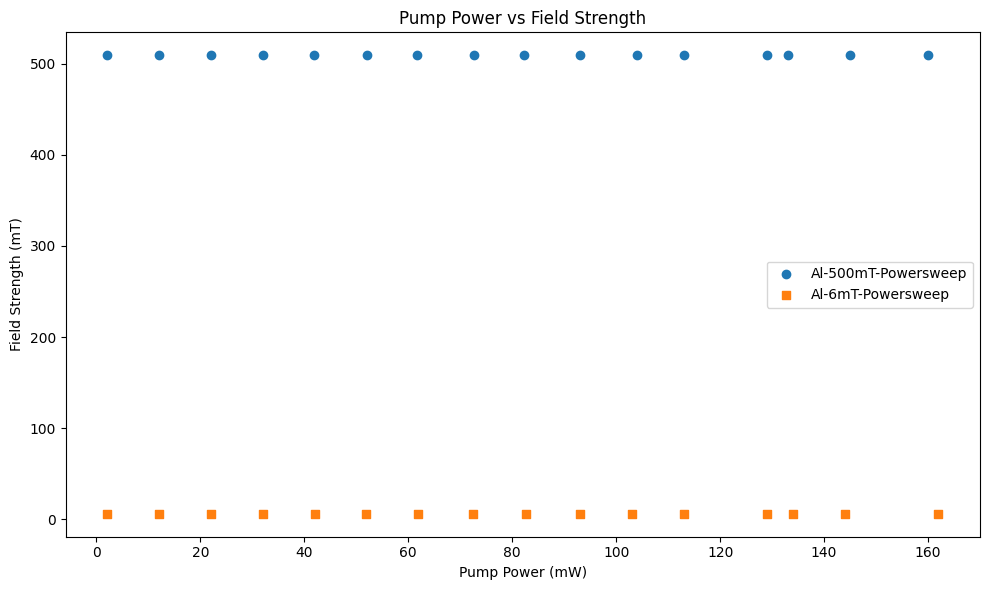

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import Reds, Blues
from natsort import natsorted
import re

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        print("Header:", header)  # For debugging
        
        # Extract field strength
        field_strength_match = re.search(r'Field strength \(mT\) = ",(\d+\.?\d*)', header)
        if field_strength_match:
            field_strength = float(field_strength_match.group(1))
            print(f"Extracted field strength: {field_strength} mT")
        else:
            print("Field strength not found in header")
            field_strength = None
        
        # Extract pump power
        pump_power_match = re.search(r'Pump power \(mW\) = ","(\d+\.?\d*)"', header)
        if pump_power_match:
            pump_power = float(pump_power_match.group(1))
            print(f"Extracted pump power: {pump_power} mW")
        else:
            print("Pump power not found in header")
            pump_power = None
        # Skip the column headers
        f.readline()
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, field_strength, data

def process_folder(folder_path, color_map,ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]
        
        ax.plot(delay_time, kerr_rotation, 'o-', color=color, markersize=3, linewidth=1,
                 label=f'{os.path.basename(folder_path)}: {pump_power:.2f} mW, {field_strength:.2f} mT')

# Set up the folders
folder1 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'
folder2 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-6mT-Powersweep'

fig,ax = plt.subplots(1,1,figsize=(12, 8))

# Process and plot data from both folders
process_folder(folder1, Reds, ax)
process_folder(folder2, Blues, ax)

plt.xlabel('Delay Time (ps)')
plt.ylabel('Kerr Rotation Signal (μV)')
plt.title('TR-MOKE Data Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.draw()

# Optional: Plot of pump powers vs. field strengths
plt.figure(figsize=(10, 6))

for folder, marker in zip([folder1, folder2], ['o', 's']):
    pump_powers = []
    field_strengths = []
    for file in os.listdir(folder):
        if file.endswith('.txt'):
            file_path = os.path.join(folder, file)
            pump_power, field_strength, _ = read_tr_moke_data(file_path)
            if pump_power is not None and field_strength is not None:
                pump_powers.append(pump_power)
                field_strengths.append(field_strength)
    
    plt.scatter(pump_powers, field_strengths, marker=marker, label=os.path.basename(folder))

plt.xlabel('Pump Power (mW)')
plt.ylabel('Field Strength (mT)')
plt.title('Pump Power vs Field Strength')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import os
import re
from matplotlib.cm import viridis
from scipy.integrate import odeint

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        # Read header
        header = f.readline().strip()
        print("Header:", header)
        
        # Updated regular expression to match the actual format
        match = re.search(r'Pump power \(mW\) = ","(\d+\.?\d*)"', header)
        if match:
            pump_power = float(match.group(1))
            print(f"Extracted pump power: {pump_power} mW")
        else:
            print("Pump power not found in header")
            pump_power = None
        
        # Skip the column headers
        f.readline()
        
        # Read data
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, data


def two_temperature_model(T, t, params):
    Te, Tl = T
    Ce, Cl, G, P0, τ = params
    
    dTedt = -G/Ce * (Te - Tl) + P0/(Ce*τ) * np.exp(-t/τ)
    dTldt = G/Cl * (Te - Tl)
    
    return [dTedt, dTldt]

def moke_signal(t, A, τr, τd, T0, Ce, Cl, G, P0, τ):
    params = [Ce, Cl, G, P0, τ]
    T_init = [T0, T0]
    solution = odeint(two_temperature_model, T_init, t, args=(params,))
    Te = solution[:, 0]
    
    return A * (1 - np.exp(-t/τr)) * np.exp(-t/τd) * (Te - T0)

C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_21.9mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_32.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_41.8mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_51.9mW_509.mT_0deg.tx

C:\Users\jc2713\AppData\Local\Temp\ipykernel_6200\3343157851.py:37: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(two_temperature_model, T_init, t, args=(params,))
C:\Users\jc2713\AppData\Local\Temp\ipykernel_6200\3343157851.py:67: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(moke_signal, fit_delay_time, fit_kerr_rotation, p0=initial_guess, maxfev=10000)


C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_104.mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_113.mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_129.mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_133.mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_145.mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_160.mW_509.mT_0deg.tx

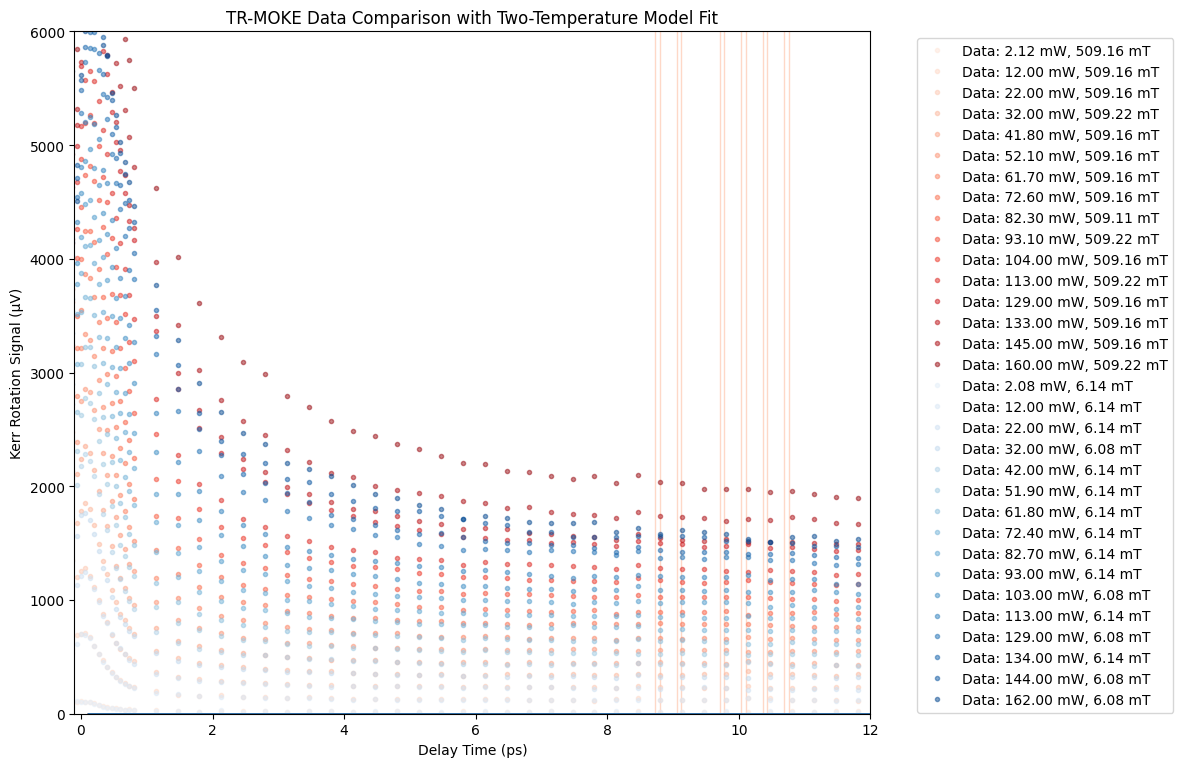

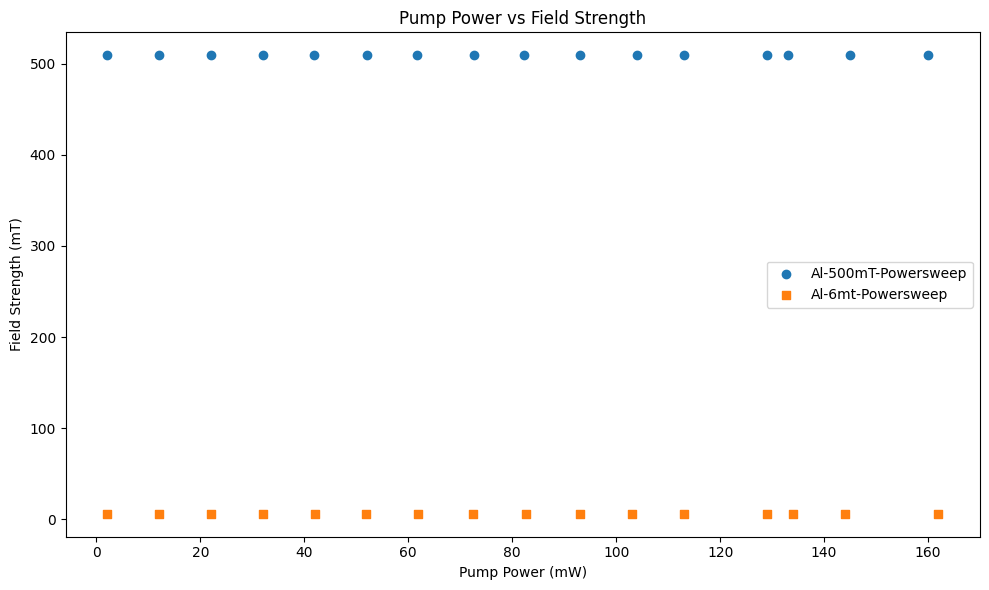

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import Reds, Blues
from natsort import natsorted
import re
from scipy.integrate import odeint
from scipy.optimize import curve_fit

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        
        field_strength_match = re.search(r'Field strength \(mT\) = ",(\d+\.?\d*)', header)
        field_strength = float(field_strength_match.group(1)) if field_strength_match else None
        
        pump_power_match = re.search(r'Pump power \(mW\) = ","(\d+\.?\d*)"', header)
        pump_power = float(pump_power_match.group(1)) if pump_power_match else None
        
        f.readline()  # Skip column headers
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, field_strength, data

def two_temperature_model(T, t, params):
    Te, Tl = T
    Ce, Cl, G, P0, τ = params
    
    dTedt = -G/Ce * (Te - Tl) + P0/(Ce*τ) * np.exp(-t/τ)
    dTldt = G/Cl * (Te - Tl)
    
    return [dTedt, dTldt]

def moke_signal(t, A, τr, τd, T0, Ce, Cl, G, P0, τ):
    params = [Ce, Cl, G, P0, τ]
    T_init = [T0, T0]
    solution = odeint(two_temperature_model, T_init, t, args=(params,))
    Te = solution[:, 0]
    
    return A * (1 - np.exp(-t/τr)) * np.exp(-t/τd) * (Te - T0)

def process_folder(folder_path, color_map, ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]
        fit_mask = delay_time > 0.1
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = kerr_rotation[fit_mask]
        #print(fit_delay_time)
        
        # Fit the two-temperature model
        initial_guess = [1, 0.1, 1, 300, 1e-22, 1e-22, 1e17, pump_power*1e-3, 0.1]
        try:
            popt, _ = curve_fit(moke_signal, fit_delay_time, fit_kerr_rotation, p0=initial_guess, maxfev=10000)
        except RuntimeError:
            print(f"Fitting failed for file {file}")
            continue
        
        # Plot raw data and fit
        delay_time_space = np.linspace(0.1,max(delay_time),400)
        ax.plot(delay_time, kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(delay_time_space, moke_signal(delay_time_space, *popt), '-', color=color, linewidth=1)

# Set up the folders
folder1 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'
folder2 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-6mt-Powersweep'

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Process and plot data from both folders
process_folder(folder1, Reds, ax)
process_folder(folder2, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison with Two-Temperature Model Fit')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(-0.1, 12)
ax.set_ylim(0,6000)
plt.tight_layout()

# Optional: Plot of pump powers vs. field strengths
fig2, ax2 = plt.subplots(figsize=(10, 6))

for folder, marker in zip([folder1, folder2], ['o', 's']):
    pump_powers = []
    field_strengths = []
    for file in os.listdir(folder):
        if file.endswith('.txt'):
            file_path = os.path.join(folder, file)
            pump_power, field_strength, _ = read_tr_moke_data(file_path)
            if pump_power is not None and field_strength is not None:
                pump_powers.append(pump_power)
                field_strengths.append(field_strength)
    
    ax2.scatter(pump_powers, field_strengths, marker=marker, label=os.path.basename(folder))

ax2.set_xlabel('Pump Power (mW)')
ax2.set_ylabel('Field Strength (mT)')
ax2.set_title('Pump Power vs Field Strength')
ax2.legend()

plt.tight_layout()
plt.show()


C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
File: av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
File: av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_21.9mW_509.mT_0deg.txt
File: av-91024-CoPtx5-Alsub-Remount_21.9mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_32.0mW_509.mT_0deg.txt
File: av-91024-CoPtx5-Alsub-Remount_32.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al

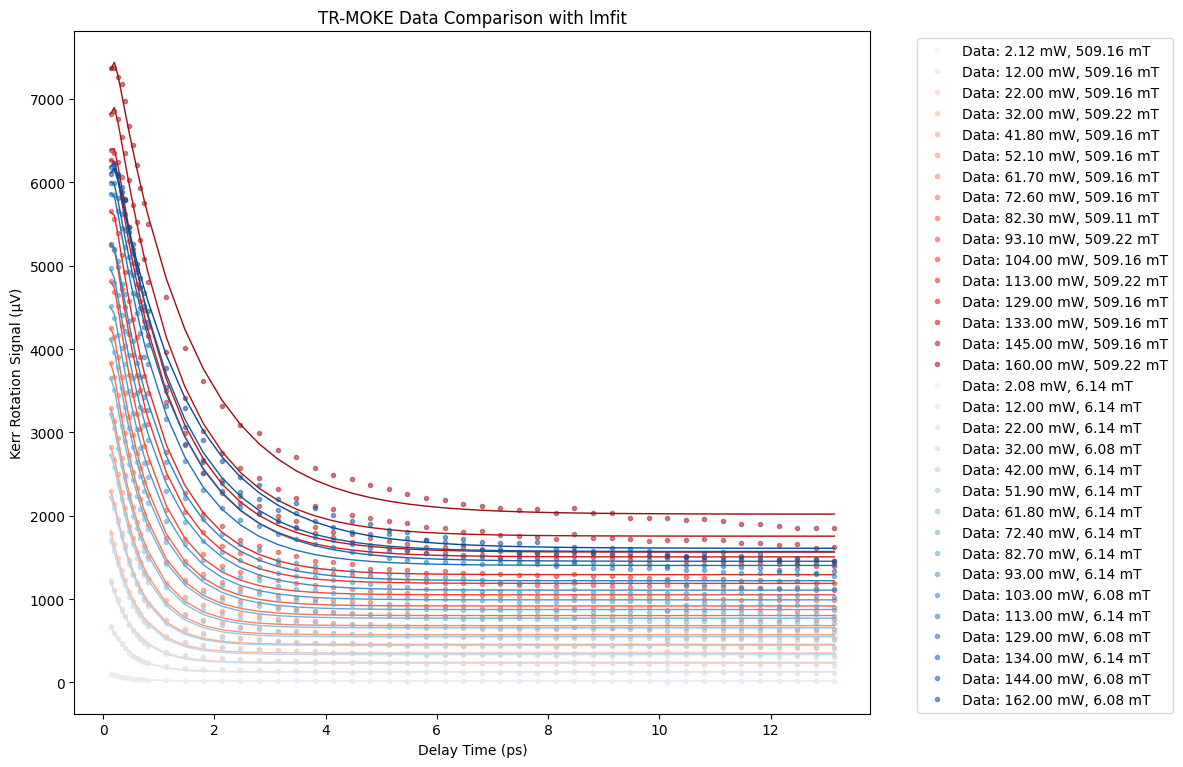

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import Reds, Blues
from natsort import natsorted
import re
from lmfit import Model, Parameters


def moke_signal(t, A, tau_r, tau_d, y0):
    return A * (1 - np.exp(-t/tau_r)) * np.exp(-t/tau_d) + y0

def process_folder(folder_path, color_map, ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]

        fit_mask = delay_time > 0.1
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = kerr_rotation[fit_mask]
        
        # Create lmfit model
        moke_model = Model(moke_signal)
        
        # Set up parameters with initial guesses
        params = Parameters()
        params.add('A', value=np.ptp(fit_kerr_rotation), min=0)
        params.add('tau_r', value=0.1, min=0)
        params.add('tau_d', value=1, min=0)
        params.add('y0', value=np.mean(fit_kerr_rotation))
        
        # Fit the model to the data
        result = moke_model.fit(fit_kerr_rotation, params, t=fit_delay_time)
        
        # Plot raw data and fit
        ax.plot(fit_delay_time, fit_kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(fit_delay_time, result.best_fit, '-', color=color, linewidth=1)
        
        # Print fit results
        print(f"File: {file}")
        #print(result.fit_report())

# The rest of your code remains the same
folder1 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'
folder2 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-6mt-Powersweep'

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

process_folder(folder1, Reds, ax)
process_folder(folder2, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison with lmfit')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_21.9mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_32.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_41.8mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_51.9mW_509.mT_0deg.tx

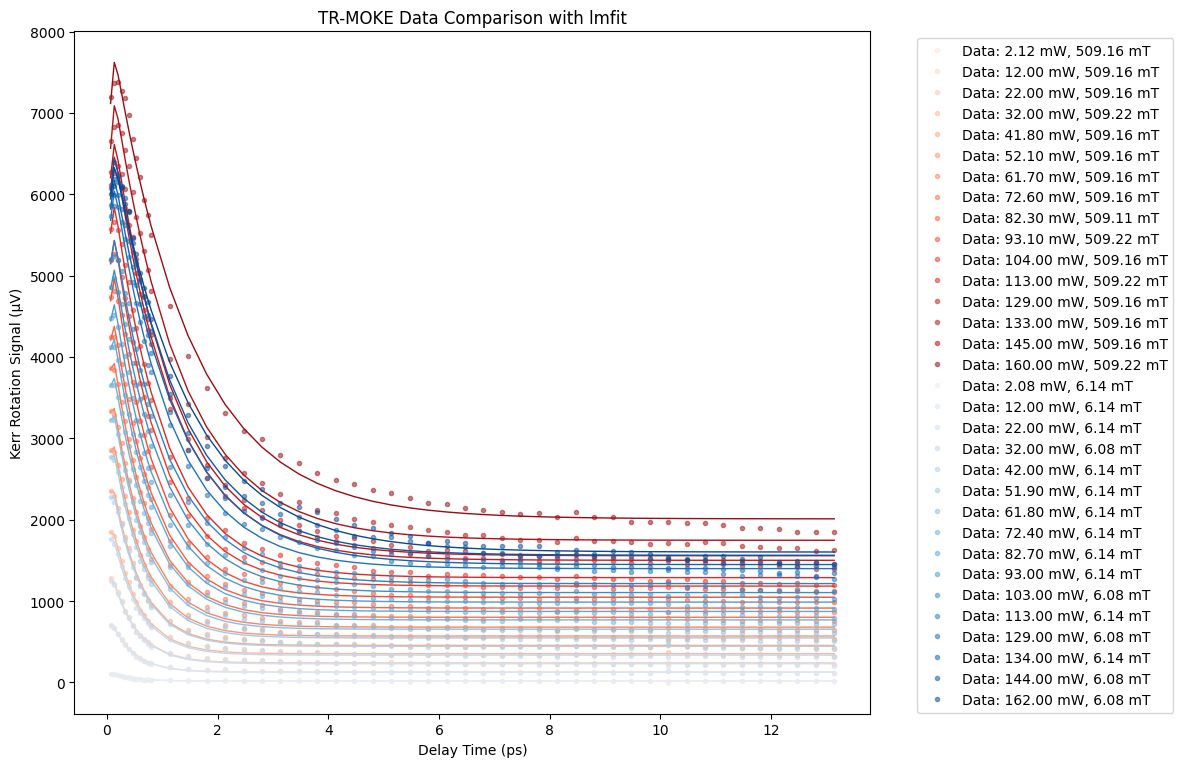

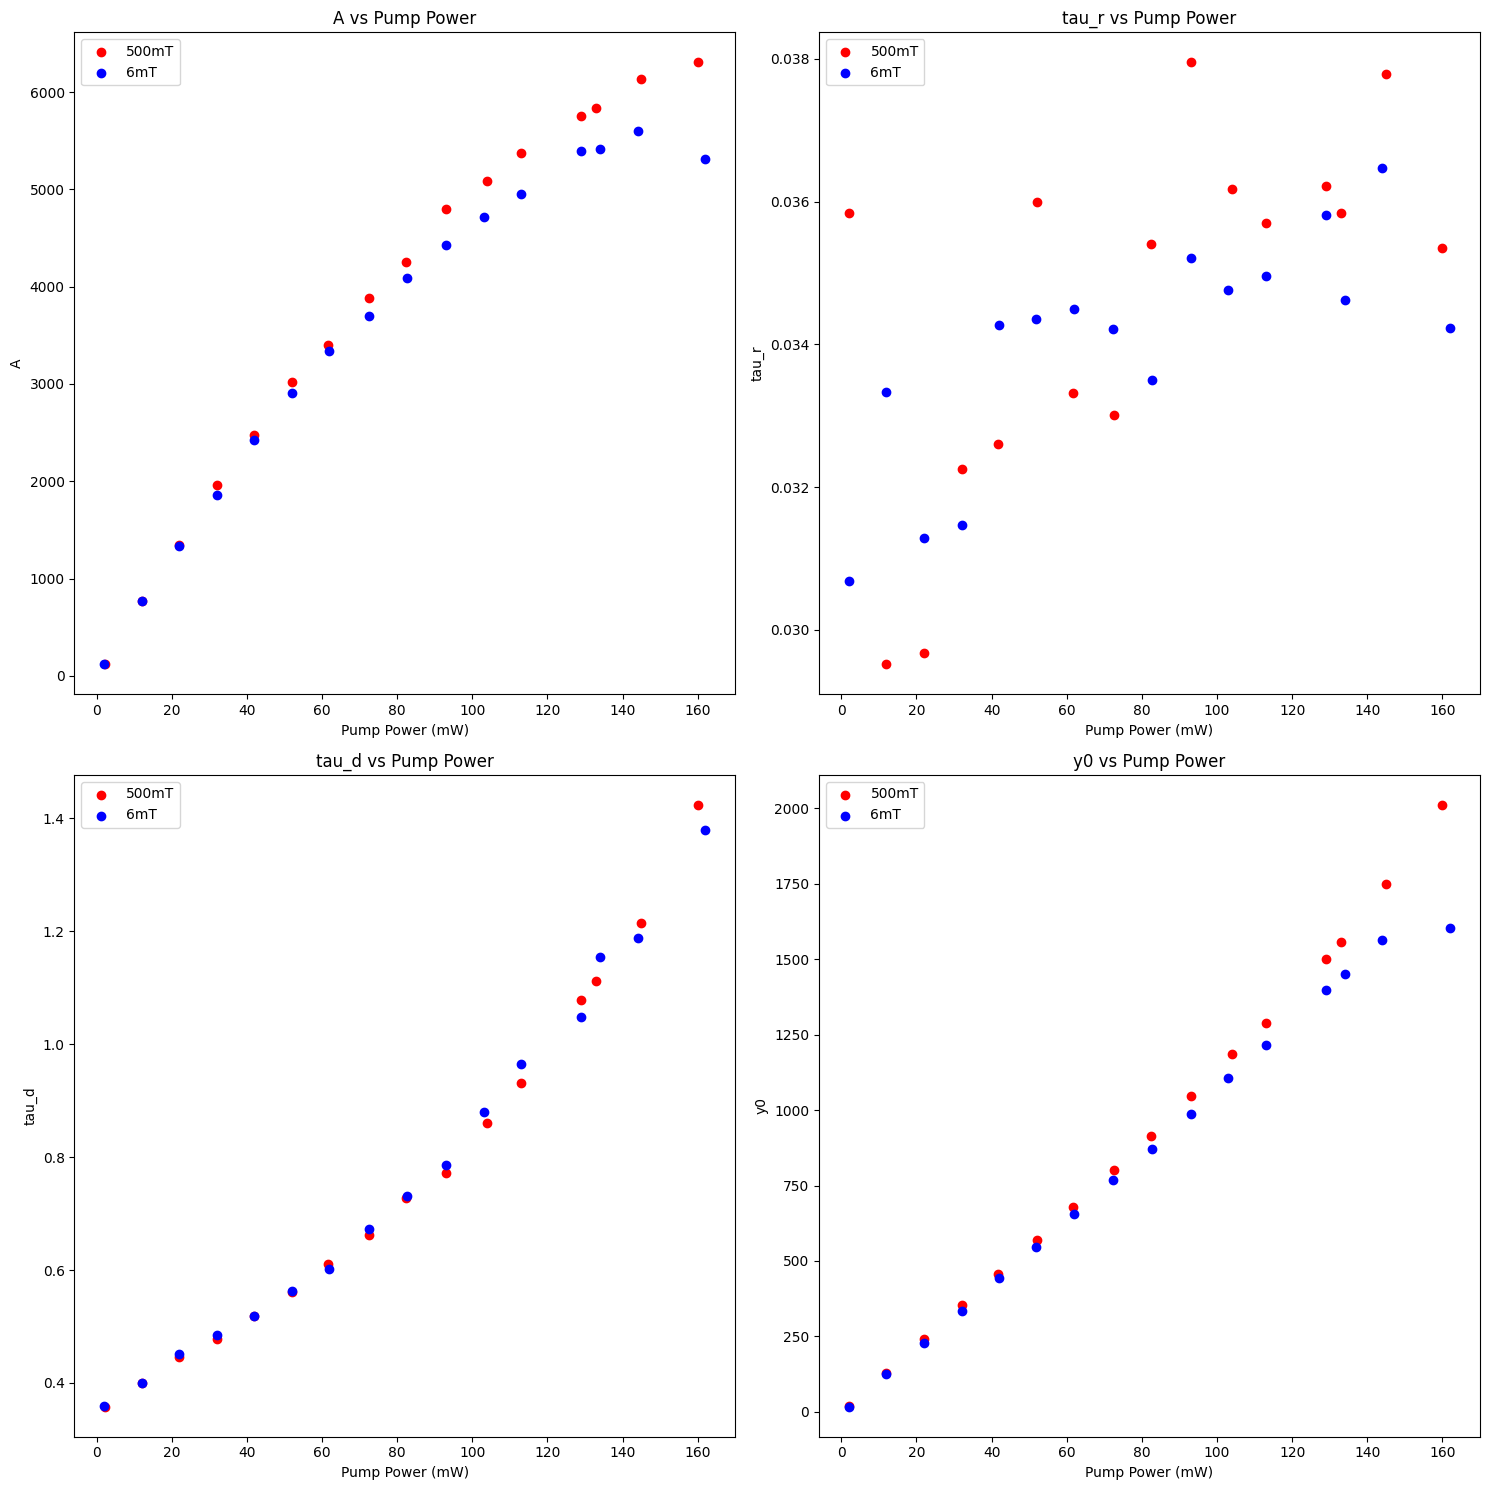

C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_21.9mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_32.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_41.8mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_51.9mW_509.mT_0deg.tx

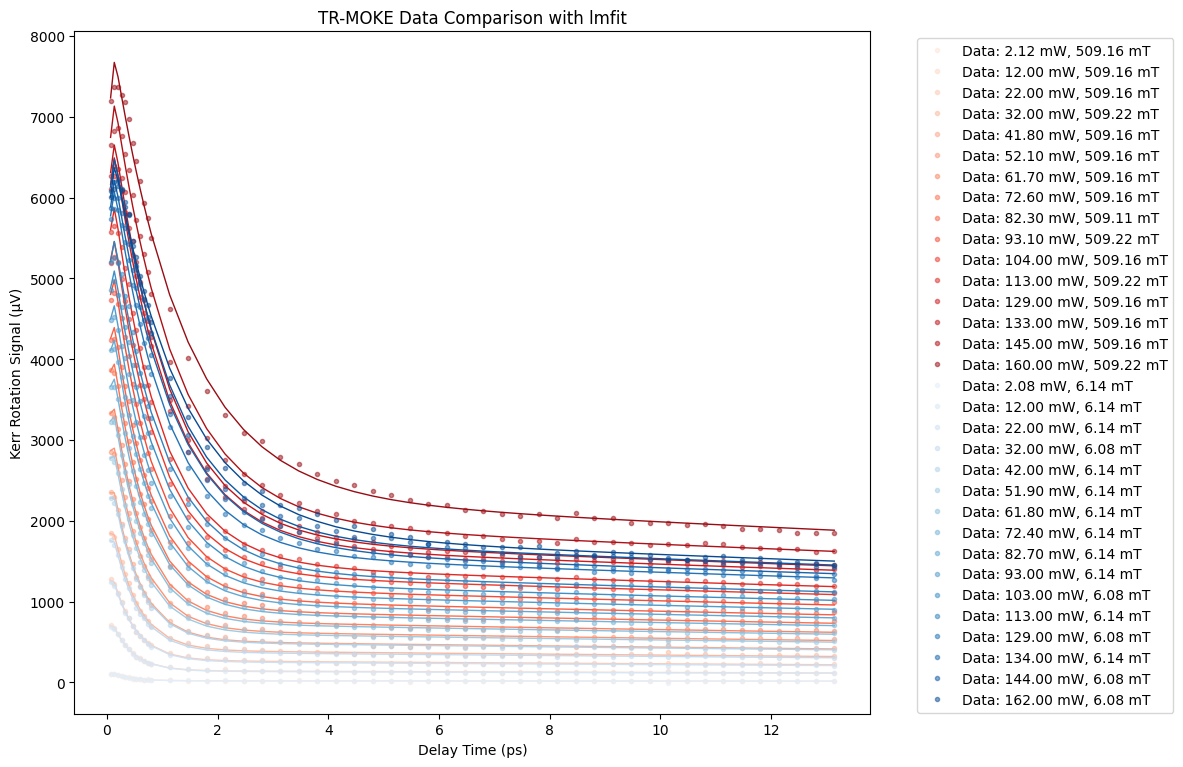

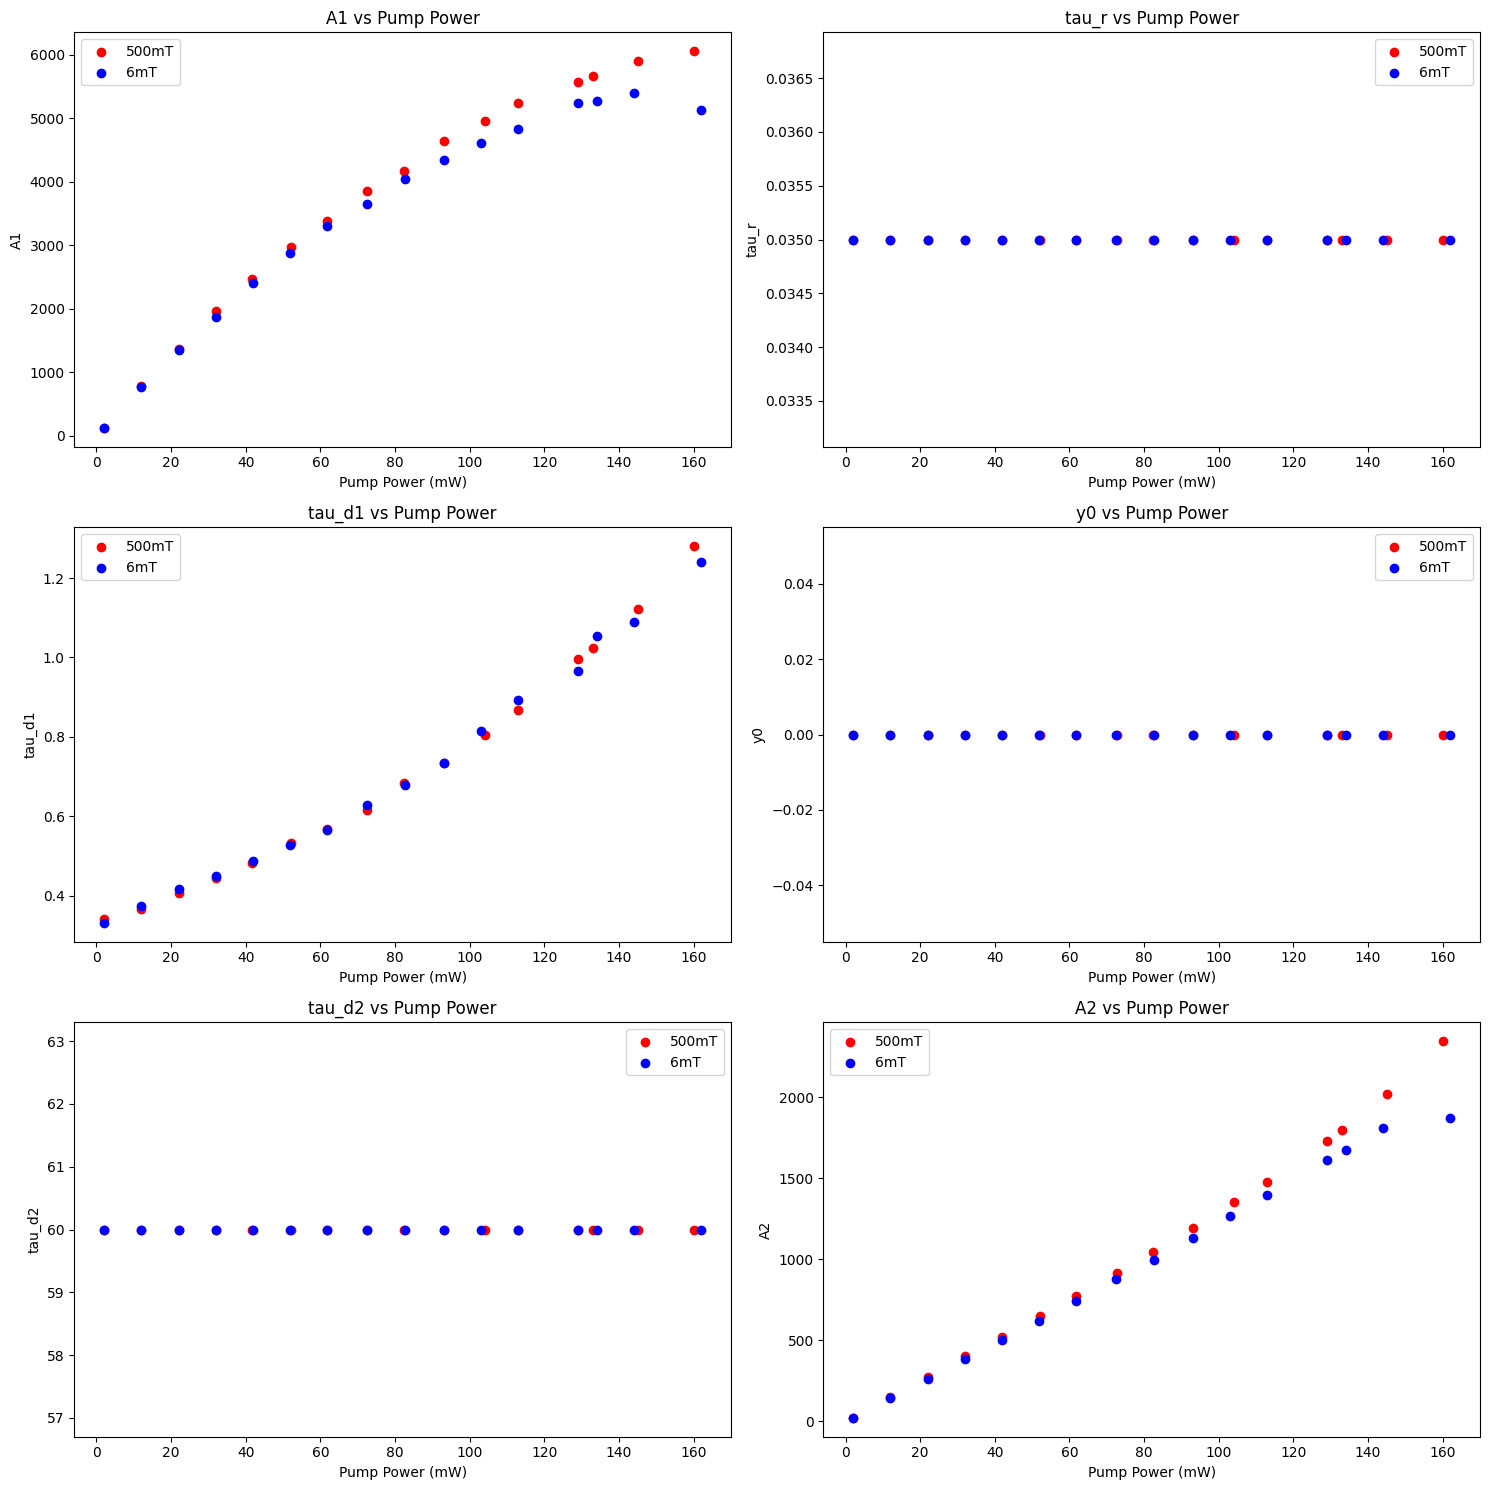

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import Reds, Blues
from natsort import natsorted
import re
from lmfit import Model, Parameters



def moke_signal(t, A, tau_r, tau_d, y0):
    return A * (1 - np.exp(-t/tau_r)) * np.exp(-t/tau_d) + y0

# Or for a double exponential model:
def moke_signal_double(t, A1, tau_r, tau_d1, A2, tau_d2, y0):
    return A1 * (1 - np.exp(-t/tau_r)) * np.exp(-t/tau_d1) + A2 * np.exp(-t/tau_d2)+y0

def process_folder_double(folder_path, color_map,ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    fit_results = []
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]

        fit_mask = delay_time > 0
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = kerr_rotation[fit_mask]
        
        # Create lmfit model
        moke_model = Model(moke_signal_double)
        
        # Set up parameters with initial guesses
        params = Parameters()
        params.add('A1', value=np.ptp(fit_kerr_rotation), min=0, max=1e5)
        params.add('tau_r', value=0.035, min=0, max = 0.1,vary=False)
        params.add('tau_d1', value=0.8, min=0,max=1.5)
        params.add('y0', value=0, max = 3000,vary=False)
        params.add('A2', value=np.ptp(fit_kerr_rotation)/3,min=0,max = 1e5)
        params.add('tau_d2', value=60, min=0, vary=False)
        #A1, tau_r, tau_d1, A2, tau_d2, y0
        
        # Fit the model to the data
        result = moke_model.fit(fit_kerr_rotation, params, t=fit_delay_time)
        
        # Plot raw data and fit
        ax.plot(fit_delay_time, fit_kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(fit_delay_time, result.best_fit, '-', color=color, linewidth=1)
        
        # Append fit results
        fit_results.append({
            'pump_power': pump_power,
            'field_strength': field_strength,
            'A1': result.params['A1'].value,
            'tau_r': result.params['tau_r'].value,
            'tau_d1': result.params['tau_d1'].value,
            'y0': result.params['y0'].value,
            'A2': result.params['A2'].value,
            'tau_d2': result.params['tau_d2'].value
        })
    return(fit_results)

def process_folder(folder_path, color_map, ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    fit_results = []
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]

        fit_mask = delay_time > 0
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = kerr_rotation[fit_mask]
        
        # Create lmfit model
        moke_model = Model(moke_signal)
        
        # Set up parameters with initial guesses
        params = Parameters()
        params.add('A', value=np.ptp(fit_kerr_rotation), min=0)
        params.add('tau_r', value=0.035, min=0)
        params.add('tau_d', value=1, min=0)
        params.add('y0', value=np.mean(fit_kerr_rotation))
        
        # Fit the model to the data
        result = moke_model.fit(fit_kerr_rotation, params, t=fit_delay_time)
        
        # Plot raw data and fit
        ax.plot(fit_delay_time, fit_kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(fit_delay_time, result.best_fit, '-', color=color, linewidth=1)
        
        # Append fit results
        fit_results.append({
            'pump_power': pump_power,
            'field_strength': field_strength,
            'A': result.params['A'].value,
            'tau_r': result.params['tau_r'].value,
            'tau_d': result.params['tau_d'].value,
            'y0': result.params['y0'].value
        })
    
    return fit_results

def plot_fit_summary(fit_results = [], labels = []):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    params = ['A', 'tau_r', 'tau_d', 'y0']
    
    for i, param in enumerate(params):
        ax = axs[i // 2, i % 2]
        
        # Plot results from folder1
        ax.scatter([r['pump_power'] for r in fit_results[0]], 
                   [r[param] for r in fit_results[0]], 
                   label=labels[0], color='red')
        
        # Plot results from folder2
        ax.scatter([r['pump_power'] for r in fit_results[1]], 
                   [r[param] for r in fit_results[1]], 
                   label=labels[1], color='blue')
        
        ax.set_xlabel('Pump Power (mW)')
        ax.set_ylabel(param)
        ax.set_title(f'{param} vs Pump Power')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_fit_summary_double(fit_results = [], labels = []):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    params = ['A1', 'tau_r', 'tau_d1', 'y0','tau_d2', 'A2']
    
    for i, param in enumerate(params):
        ax = axs[i // 2, i % 2]
        
        # Plot results from folder1
        ax.scatter([r['pump_power'] for r in fit_results[0]], 
                   [r[param] for r in fit_results[0]], 
                   label=labels[0], color='red')
        
        # Plot results from folder2
        ax.scatter([r['pump_power'] for r in fit_results[1]], 
                   [r[param] for r in fit_results[1]], 
                   label=labels[1], color='blue')
        
        ax.set_xlabel('Pump Power (mW)')
        ax.set_ylabel(param)
        ax.set_title(f'{param} vs Pump Power')
        ax.legend()
    
    plt.tight_layout()

# The rest of your code
folder1 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'
folder2 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-6mt-Powersweep'

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fit_results1 = process_folder(folder1, Reds, ax)
fit_results2 = process_folder(folder2, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison with lmfit')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot summary of fit parameters
plot_fit_summary(fit_results = [fit_results1, fit_results2], labels = ['500mT', '6mT'])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fit_results1_d = process_folder_double(folder1, Reds, ax)
fit_results2_d = process_folder_double(folder2, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison with lmfit')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot summary of fit parameters
plot_fit_summary_double(fit_results = [fit_results1_d, fit_results2_d], labels = ['500mT', '6mT'])


C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep\av-91024-CoPt5x-SiSiO2sub_2.04mW_-457.mT_45deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep\av-91024-CoPt5x-SiSiO2sub_2.09mW_-1261mT_45deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep\av-91024-CoPt5x-SiSiO2sub_11.9mW_-480.mT_45deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep\av-91024-CoPt5x-SiSiO2sub_20.0mW_550.mT_45deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep\av-91024-CoPt5x-SiSiO2sub_21.9mW_-512.mT_45deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep\av-91024-CoPt5x-SiSiO2sub_32.0mW_-613.mT_45deg.txt
C:\Users\jc

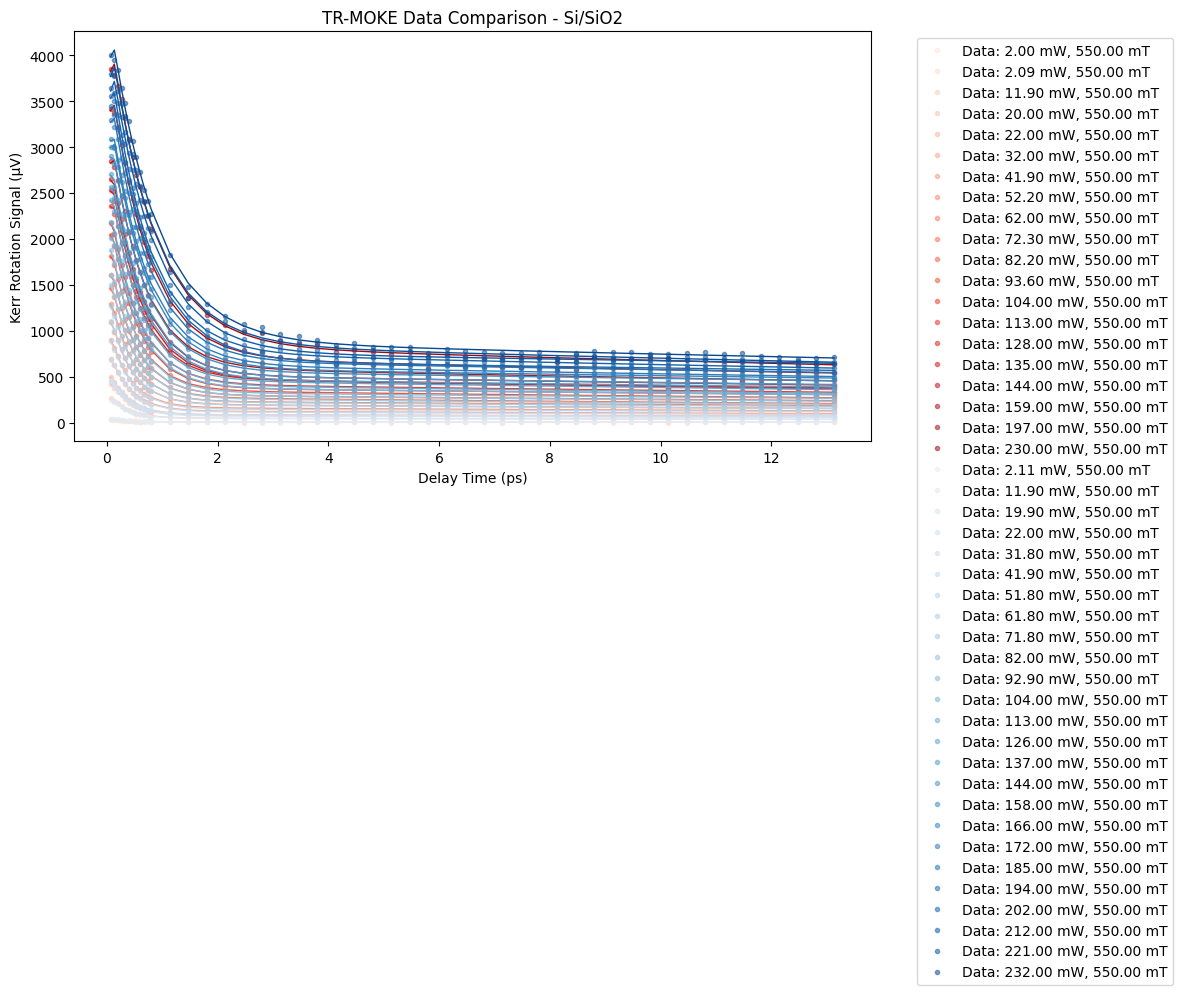

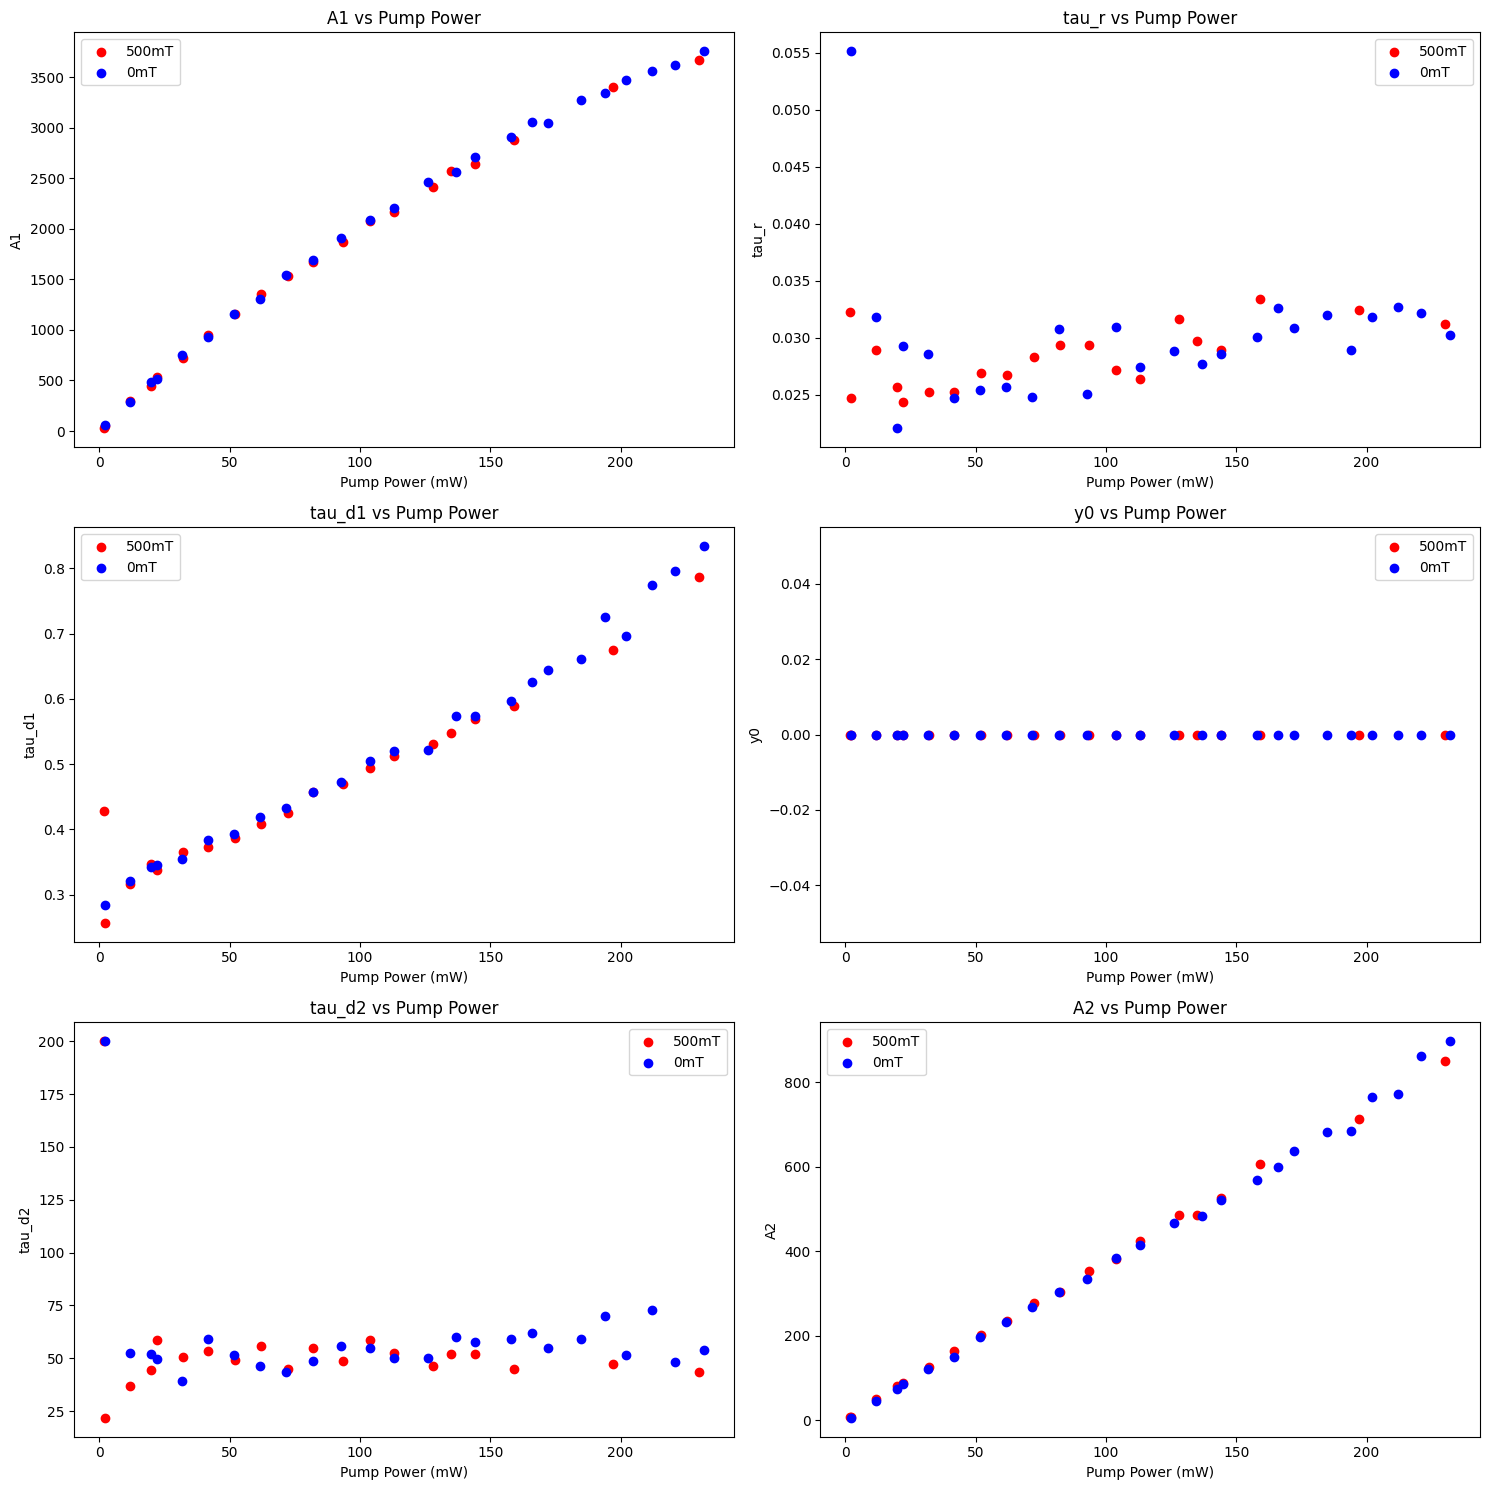

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
import os


folderSi_500 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep'
folderSi_0 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-0mT-Powersweep'
folderAl_500 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'
folderAl_0 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-0mT-Powersweep'

def process_folder_double(folder_path, color_map,ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    fit_results = []
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]

        fit_mask = delay_time > 0
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = kerr_rotation[fit_mask]
        
        # Create lmfit model
        moke_model = Model(moke_signal_double)
        
        # Set up parameters with initial guesses
        params = Parameters()
        params.add('A1', value=np.ptp(fit_kerr_rotation), min=0, max=1e5)
        params.add('tau_r', value=0.035, min=0, max = 0.1,vary=True)
        params.add('tau_d1', value=0.8, min=0,max=1.5)
        params.add('y0', value=0, max = 3000,vary=False)
        params.add('A2', value=np.ptp(fit_kerr_rotation)/3,min=0,max = 1e5)
        params.add('tau_d2', value=60, min=0,max=200, vary=True)
        #A1, tau_r, tau_d1, A2, tau_d2, y0
        
        # Fit the model to the data
        result = moke_model.fit(fit_kerr_rotation, params, t=fit_delay_time)
        
        # Plot raw data and fit
        ax.plot(fit_delay_time, fit_kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(fit_delay_time, result.best_fit, '-', color=color, linewidth=1)
        
        # Append fit results
        fit_results.append({
            'pump_power': pump_power,
            'field_strength': field_strength,
            'A1': result.params['A1'].value,
            'tau_r': result.params['tau_r'].value,
            'tau_d1': result.params['tau_d1'].value,
            'y0': result.params['y0'].value,
            'A2': result.params['A2'].value,
            'tau_d2': result.params['tau_d2'].value
        })
    return(fit_results)

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        
        field_strength_match = re.search(r'Field strength \(mT\) = ",(\d+\.?\d*)', header)
        field_strength = float(field_strength_match.group(1)) if field_strength_match else 550.
        
        pump_power_match = re.search(r'Pump power \(mW\) = ","(\d+\.?\d*)"', header)
        pump_power = float(pump_power_match.group(1)) if pump_power_match else None
        
        f.readline()  # Skip column headers
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, field_strength, data


# Plot summary of fit parameters

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fit_results1_d = process_folder_double(folderSi_500, Reds, ax)
fit_results2_d = process_folder_double(folderSi_0, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison - Si/SiO2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot summary of fit parameters
plot_fit_summary_double(fit_results = [fit_results1_d, fit_results2_d], labels = ['500mT', '0mT'])

C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-20mW-Fieldsweep\av-91024-CoPt5x-SiSiO2sub-fieldscan_107.mW_56.1mT_45deg.txt
Skipping file av-91024-CoPt5x-SiSiO2sub-fieldscan_107.mW_56.1mT_45deg.txt due to missing pump power or field strength
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-20mW-Fieldsweep\av-91024-CoPt5x-SiSiO2sub-fieldscan_107.mW_77.4mT_45deg.txt
Skipping file av-91024-CoPt5x-SiSiO2sub-fieldscan_107.mW_77.4mT_45deg.txt due to missing pump power or field strength
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-20mW-Fieldsweep\av-91024-CoPt5x-SiSiO2sub-fieldscan_107.mW_-50.2mT_45deg.txt
Skipping file av-91024-CoPt5x-SiSiO2sub-fieldscan_107.mW_-50.2mT_45deg.txt due to missing pump power or field strength
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-20mW-Fieldsweep\av-91024-CoP

C:\Users\jc2713\AppData\Local\Temp\ipykernel_6200\4241994259.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


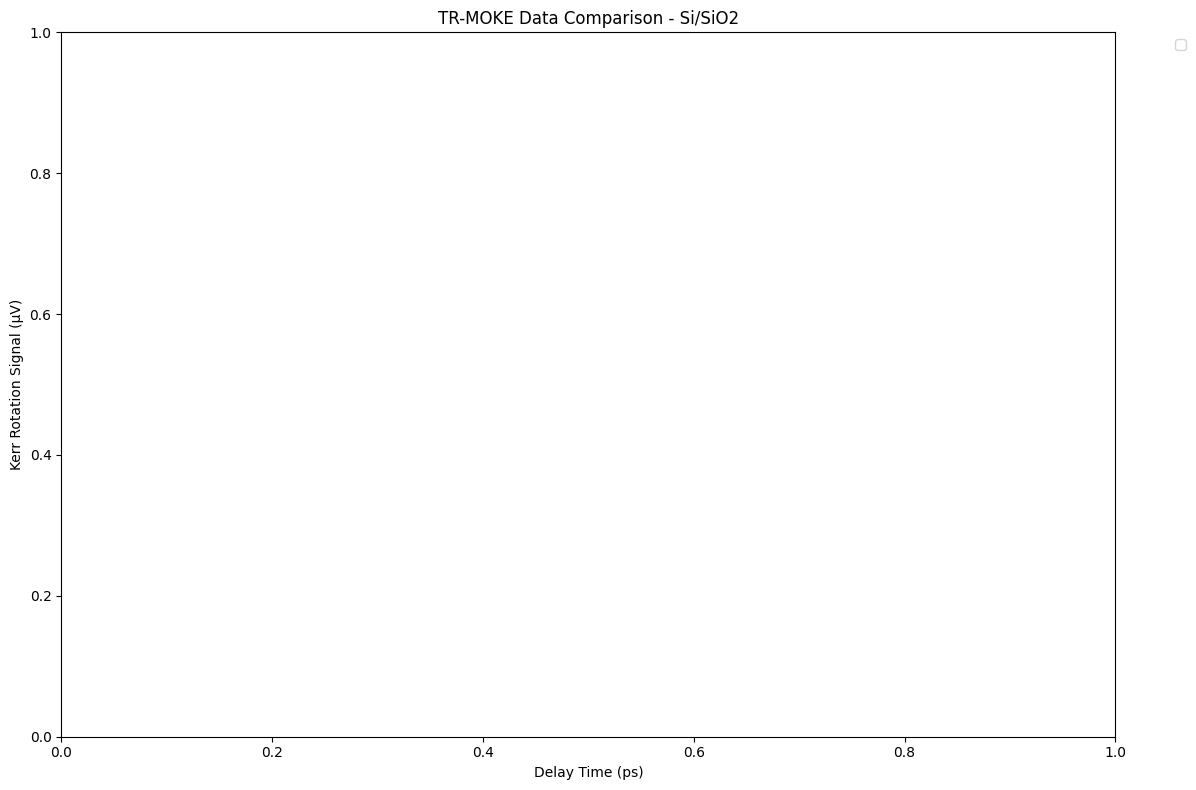

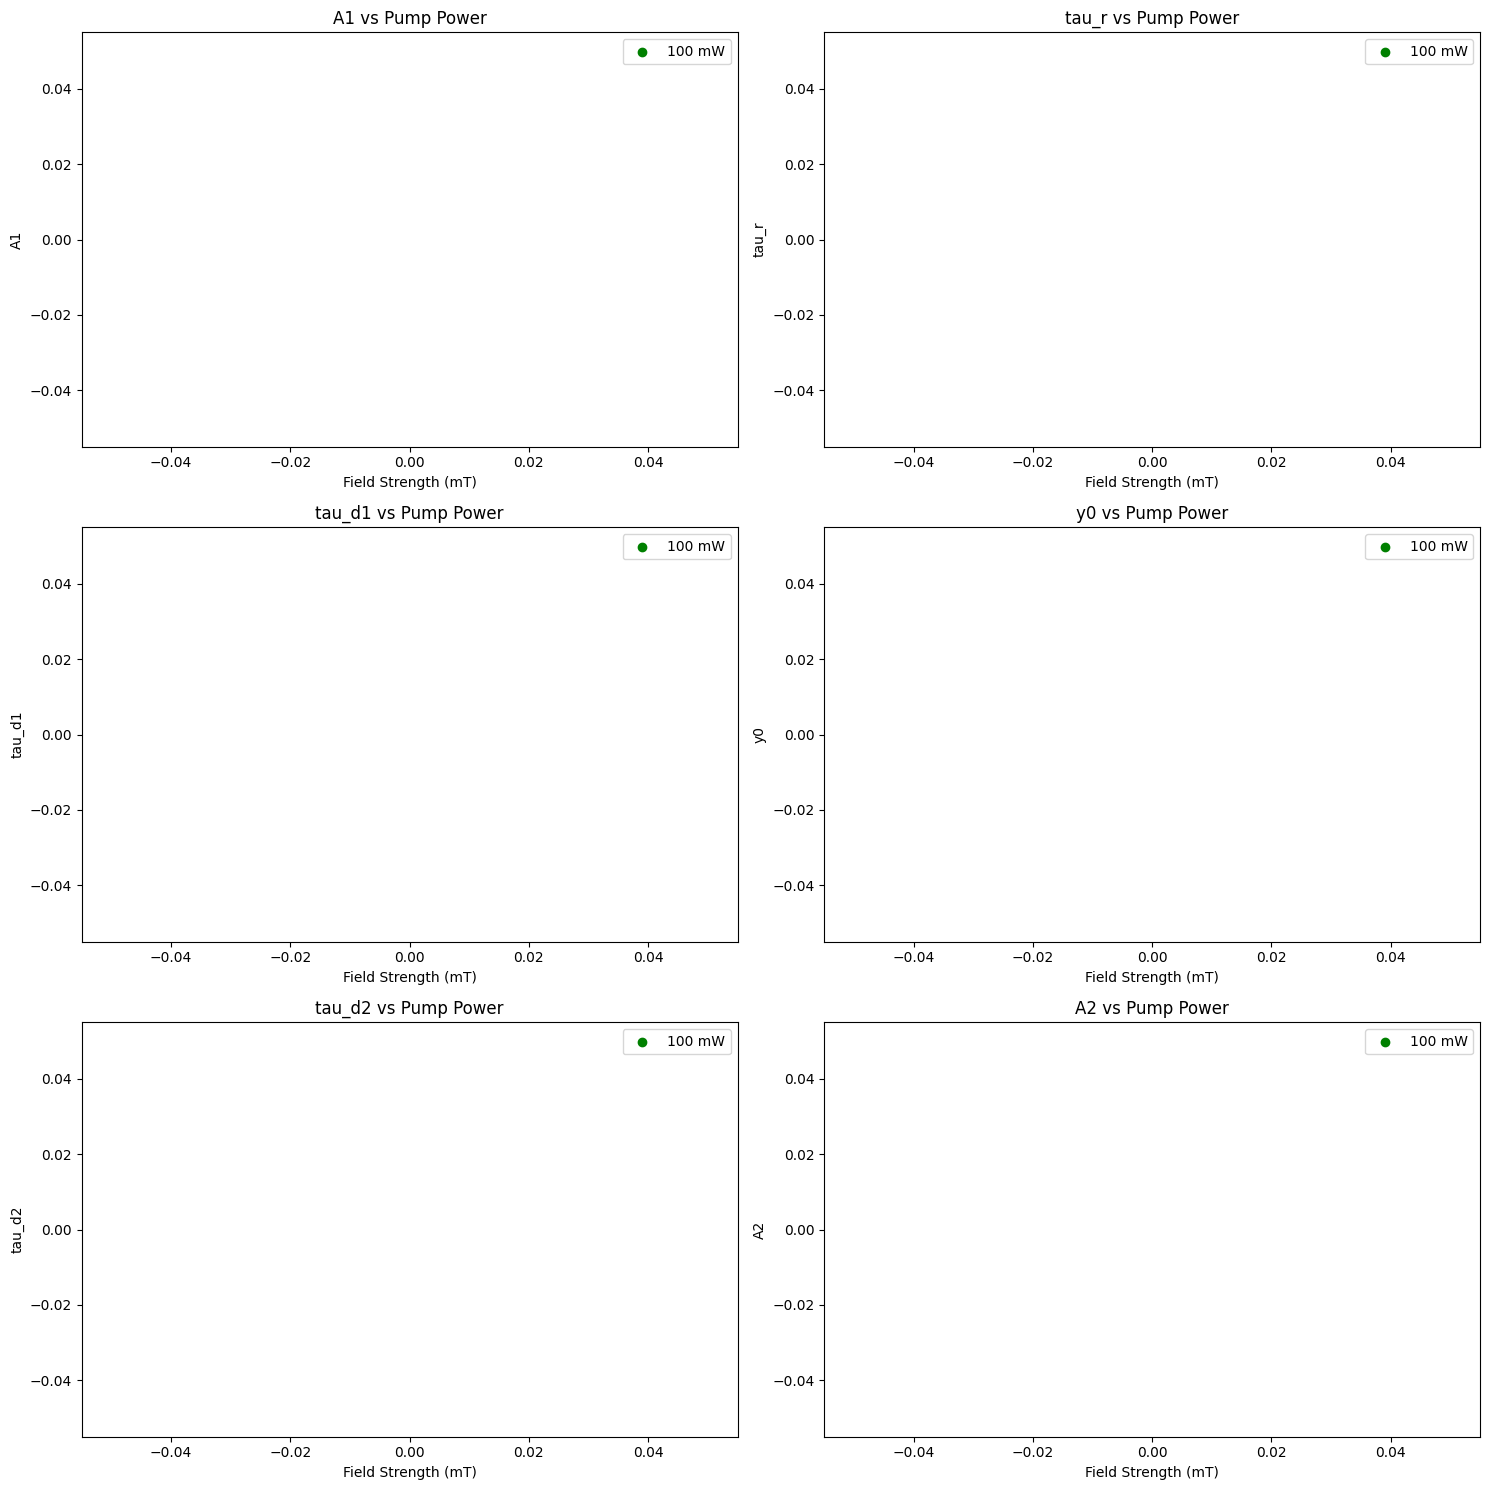

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from matplotlib.cm import Greens


folderSi_500 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep'
folderSi_0 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-0mT-Powersweep'
folderAl_500 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'
folderAl_0 = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-0mT-Powersweep'

folderSi_field = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-20mW-Fieldsweep'


import re
import numpy as np
from typing import Dict, List, Tuple

def read_data(filename: str) -> Tuple[Dict[str, float], List[str], np.ndarray]:
    """
    Read TR-MOKE data from a file, extracting metadata, column headers, and data.

    Args:
        filename (str): Path to the data file.

    Returns:
        Tuple[Dict[str, float], List[str], np.ndarray]: 
            - Dictionary of metadata
            - List of column headers
            - NumPy array of data
    """
    metadata_patterns = {
        'field_strength': r'Field strength \(mT\) = ",(-?\d+\.?\d*)',
        'pump_power': r'Pump power \(mW\) = ",([-+]?\d*\.?\d+)',
        'add_number': r'Add number = ",(\d+)',
        'original_stage_position': r'Original stage position =",(\d+)',
        'field_id': r'Field ID = ",(-?\d+)',
        'expected_field': r'Expected field \(mT\) = ",(-?\d+\.?\d*)',
        'hwp_angle_probe': r'HWP angle \(probe\) = ",(\d+\.?\d*)',
        'hwp_angle_pump': r'HWP angle \(pump\) = ",(\d+\.?\d*)',
        'qwp_angle_pump': r'QWP angle \(pump\) = ",(\d+)',
        'reflectance': r'reflectance = ",(\d+)'
    }

    metadata = {}
    column_headers = []

    with open(filename, 'r') as file:
        # Read and parse header
        header = file.readline().strip()
        for key, pattern in metadata_patterns.items():
            match = re.search(pattern, header)
            if match:
                value = match.group(1)
                metadata[key] = float(value) if '.' in value else int(value)

        # Read column headers
        column_headers = [header.strip(' "') for header in file.readline().strip().split(',')]

        # Read data
        data = np.loadtxt(file, delimiter=',', usecols=(1, 2, 3, 4))

    return metadata, column_headers, data




def process_folder_double(folder_path, color_map,ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    fit_results = []
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]

        fit_mask = delay_time > 0
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = abs(kerr_rotation[fit_mask])
        
        # Create lmfit model
        moke_model = Model(moke_signal_double)
        
        # Set up parameters with initial guesses
        params = Parameters()
        params.add('A1', value=np.ptp(fit_kerr_rotation), min=0, max=1e5)
        params.add('tau_r', value=0.035, min=0, max = 0.1,vary=True)
        params.add('tau_d1', value=0.8, min=0,max=1.5)
        params.add('y0', value=0, max = 3000,vary=False)
        params.add('A2', value=np.ptp(fit_kerr_rotation)/3,min=0,max = 1e5)
        params.add('tau_d2', value=60, min=0,max=200, vary=True)
        #A1, tau_r, tau_d1, A2, tau_d2, y0
        
        # Fit the model to the data
        result = moke_model.fit(fit_kerr_rotation, params, t=fit_delay_time)
        
        # Plot raw data and fit
        ax.plot(fit_delay_time, fit_kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(fit_delay_time, result.best_fit, '-', color=color, linewidth=1)
        
        # Append fit results
        fit_results.append({
            'pump_power': pump_power,
            'field_strength': field_strength,
            'A1': result.params['A1'].value,
            'tau_r': result.params['tau_r'].value,
            'tau_d1': result.params['tau_d1'].value,
            'y0': result.params['y0'].value,
            'A2': result.params['A2'].value,
            'tau_d2': result.params['tau_d2'].value
        })
    return(fit_results)

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        
        field_strength_match = re.search(r'Field strength \(mT\) = ","([-+]?\d*\.?\d+)"', header)
        field_strength = float(field_strength_match.group(1)) if field_strength_match else None
        
        pump_power_match = re.search(r'Pump power \(mW\) = ","([-+]?\d*\.?\d+)"', header)
        pump_power = float(pump_power_match.group(1)) if pump_power_match else None
        
        f.readline()  # Skip column headers
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, field_strength, data


def plot_fit_summary_double(fit_results = [], labels = []):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    params = ['A1', 'tau_r', 'tau_d1', 'y0','tau_d2', 'A2']
    
    for i, param in enumerate(params):
        ax = axs[i // 2, i % 2]
        
        # Plot results from folder1
        ax.scatter([r['field_strength'] for r in fit_results[0]], 
                   [r[param] for r in fit_results[0]], 
                   label=labels[0], color='green')
               
        ax.set_xlabel('Field Strength (mT)')
        ax.set_ylabel(param)
        ax.set_title(f'{param} vs Pump Power')
        ax.legend()
    
    plt.tight_layout()
# Plot summary of fit parameters

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fit_results1_d = process_folder_double(folderSi_field, Greens, ax)
#fit_results2_d = process_folder_double(folderSi_0, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison - Si/SiO2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot summary of fit parameters
plot_fit_summary_double(fit_results = [fit_results1_d], labels = ['100 mW'])

C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-0mT-Powersweep\av-041024-CoPtx1-Alsub_2.13mW_-1424mT_0deg.txt
Skipping file av-041024-CoPtx1-Alsub_2.13mW_-1424mT_0deg.txt due to missing pump power or field strength
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-0mT-Powersweep\av-041024-CoPtx1-Alsub_12.0mW_-1424mT_0deg.txt
Skipping file av-041024-CoPtx1-Alsub_12.0mW_-1424mT_0deg.txt due to missing pump power or field strength
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-0mT-Powersweep\av-041024-CoPtx1-Alsub_21.9mW_-1424mT_0deg.txt
Skipping file av-041024-CoPtx1-Alsub_21.9mW_-1424mT_0deg.txt due to missing pump power or field strength
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-0mT-Powersweep\av-041024-CoPtx1-Alsub_31.8mW_-1424mT_0deg.txt
Skipping file av-0410

C:\Users\jc2713\AppData\Local\Temp\ipykernel_6200\1122407931.py:134: UserWarning: loadtxt: input contained no data: "<_io.TextIOWrapper name='C:\\Users\\jc2713\\OneDrive - Imperial College London (1)\\Tohoku - pump priming\\Data\\TRMOKE\\1022\\Al-CoPt1x-500mT-Powersweep\\av-041024-CoPtx1-Alsub_93.4mW_-1215mT_0deg.txt' mode='r' encoding='cp1252'>"
  data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
C:\Users\jc2713\AppData\Local\Temp\ipykernel_6200\1122407931.py:167: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


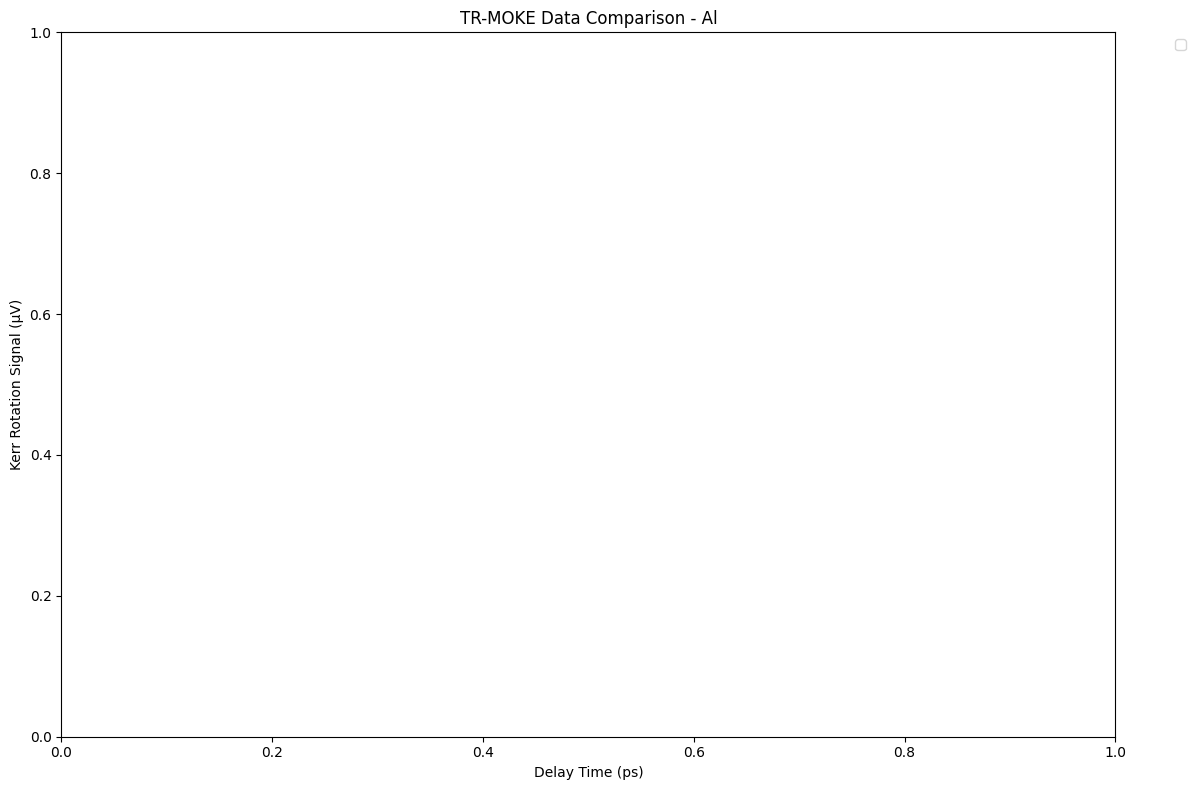

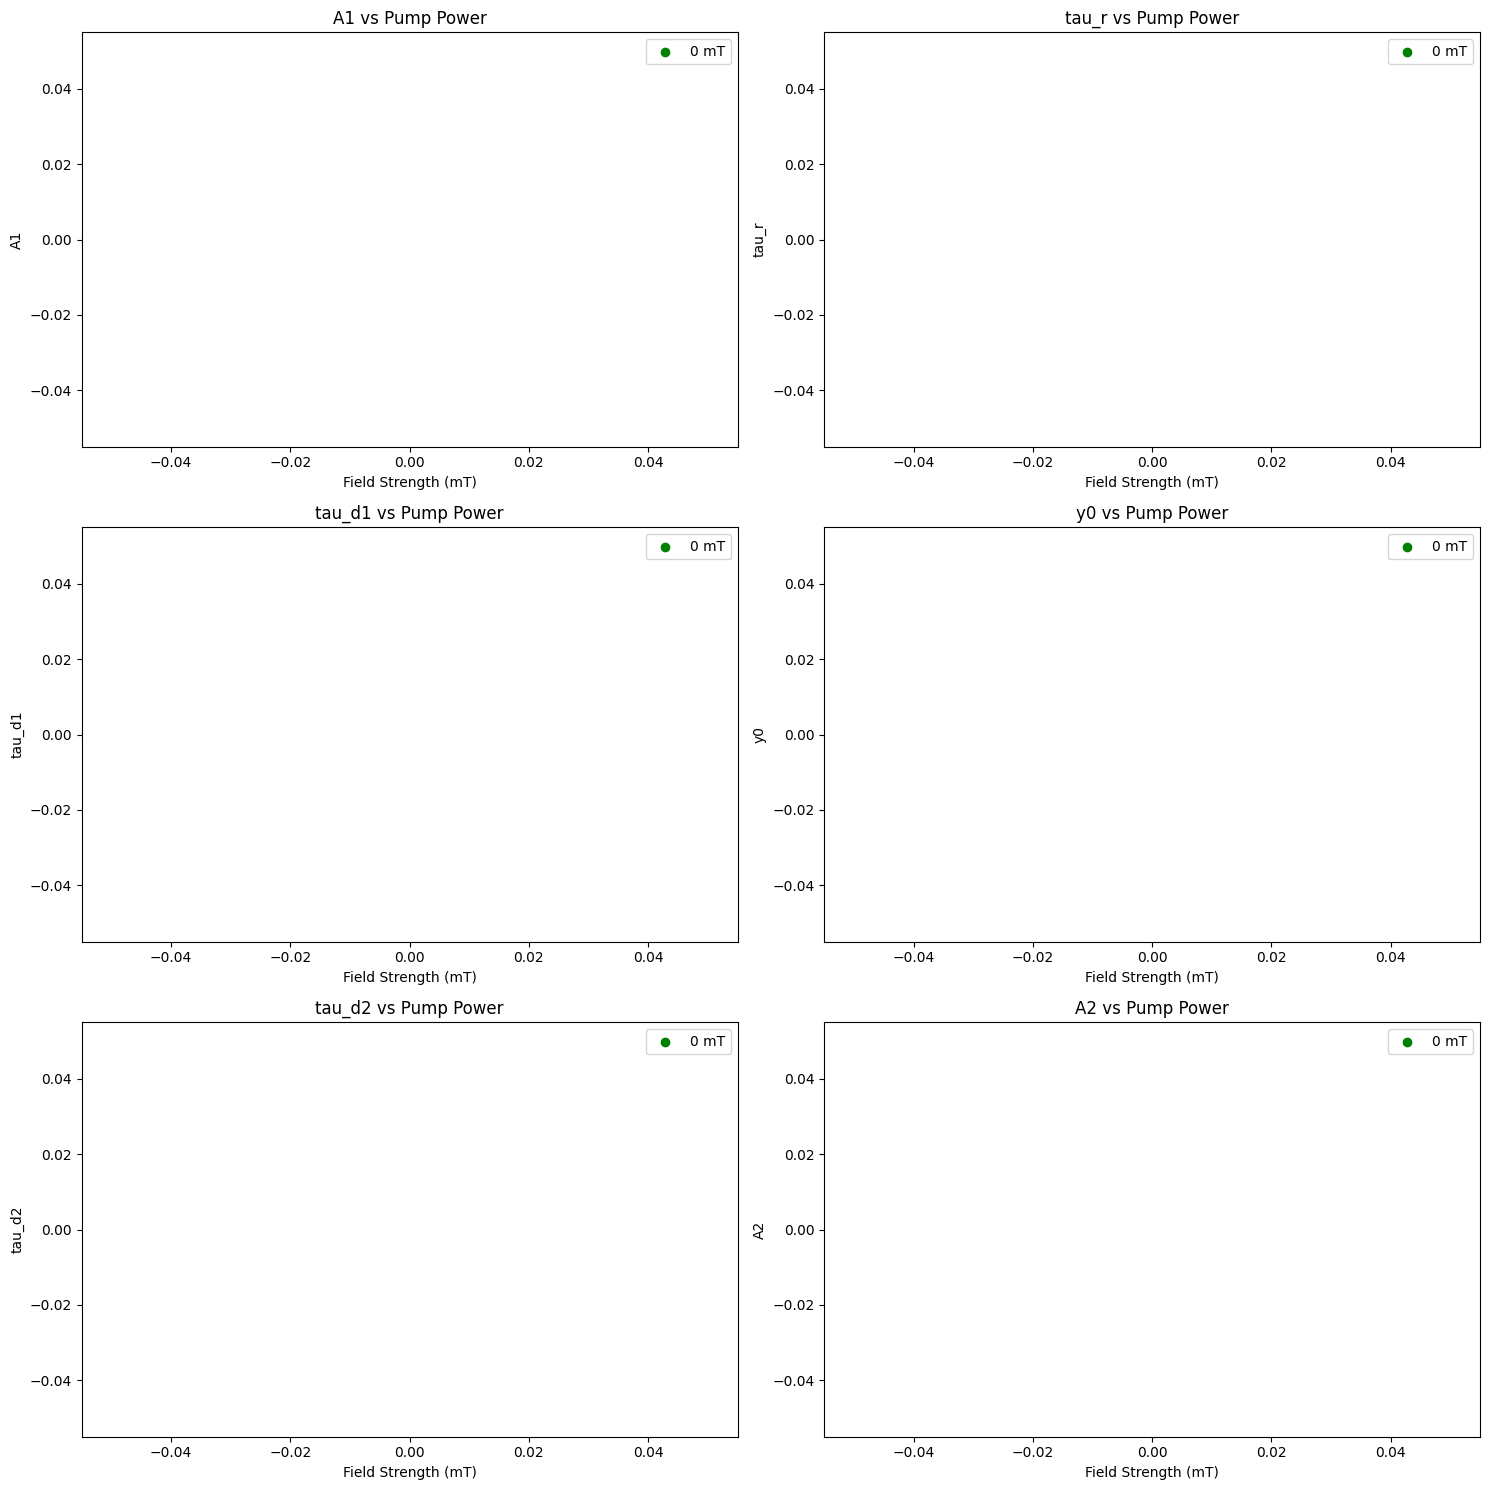

In [51]:
folder_al_1x_0mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-0mT-Powersweep'
folder_al_1x_500mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-500mT-Powersweep'


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from matplotlib.cm import Greens

import re
import numpy as np
from typing import Dict, List, Tuple

def read_data(filename: str) -> Tuple[Dict[str, float], List[str], np.ndarray]:
    """
    Read TR-MOKE data from a file, extracting metadata, column headers, and data.

    Args:
        filename (str): Path to the data file.

    Returns:
        Tuple[Dict[str, float], List[str], np.ndarray]: 
            - Dictionary of metadata
            - List of column headers
            - NumPy array of data
    """
    metadata_patterns = {
        'field_strength': r'Field strength \(mT\) = ",(-?\d+\.?\d*)',
        'pump_power': r'Pump power \(mW\) = ",([-+]?\d*\.?\d+)',
        'add_number': r'Add number = ",(\d+)',
        'original_stage_position': r'Original stage position =",(\d+)',
        'field_id': r'Field ID = ",(-?\d+)',
        'expected_field': r'Expected field \(mT\) = ",(-?\d+\.?\d*)',
        'hwp_angle_probe': r'HWP angle \(probe\) = ",(\d+\.?\d*)',
        'hwp_angle_pump': r'HWP angle \(pump\) = ",(\d+\.?\d*)',
        'qwp_angle_pump': r'QWP angle \(pump\) = ",(\d+)',
        'reflectance': r'reflectance = ",(\d+)'
    }

    metadata = {}
    column_headers = []

    with open(filename, 'r') as file:
        # Read and parse header
        header = file.readline().strip()
        for key, pattern in metadata_patterns.items():
            match = re.search(pattern, header)
            if match:
                value = match.group(1)
                metadata[key] = float(value) if '.' in value else int(value)

        # Read column headers
        column_headers = [header.strip(' "') for header in file.readline().strip().split(',')]

        # Read data
        data = np.loadtxt(file, delimiter=',', usecols=(1, 2, 3, 4))

    return metadata, column_headers, data




def process_folder_double(folder_path, color_map,ax):
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    data_files_sorted = natsorted(data_files)
    
    colors = color_map(np.linspace(0.1, 0.9, len(data_files_sorted)))
    
    fit_results = []
    
    for file, color in zip(data_files_sorted, colors):
        file_path = os.path.join(folder_path, file)
        print(file_path)
        pump_power, field_strength, data = read_tr_moke_data(file_path)
        
        if pump_power is None or field_strength is None:
            print(f"Skipping file {file} due to missing pump power or field strength")
            continue
        
        delay_time = data[:, 0]
        kerr_rotation = data[:, 1]

        fit_mask = delay_time > 0
        fit_delay_time = delay_time[fit_mask]
        fit_kerr_rotation = abs(kerr_rotation[fit_mask])
        
        # Create lmfit model
        moke_model = Model(moke_signal_double)
        
        # Set up parameters with initial guesses
        params = Parameters()
        params.add('A1', value=np.ptp(fit_kerr_rotation), min=0, max=1e5)
        params.add('tau_r', value=0.035, min=0, max = 0.1,vary=True)
        params.add('tau_d1', value=0.8, min=0,max=1.5)
        params.add('y0', value=0, max = 3000,vary=False)
        params.add('A2', value=np.ptp(fit_kerr_rotation)/3,min=0,max = 1e5)
        params.add('tau_d2', value=60, min=0,max=200, vary=True)
        #A1, tau_r, tau_d1, A2, tau_d2, y0
        
        # Fit the model to the data
        result = moke_model.fit(fit_kerr_rotation, params, t=fit_delay_time)
        
        # Plot raw data and fit
        ax.plot(fit_delay_time, fit_kerr_rotation, 'o', color=color, markersize=3, alpha=0.5,
                label=f'Data: {pump_power:.2f} mW, {field_strength:.2f} mT')
        ax.plot(fit_delay_time, result.best_fit, '-', color=color, linewidth=1)
        
        # Append fit results
        fit_results.append({
            'pump_power': pump_power,
            'field_strength': field_strength,
            'A1': result.params['A1'].value,
            'tau_r': result.params['tau_r'].value,
            'tau_d1': result.params['tau_d1'].value,
            'y0': result.params['y0'].value,
            'A2': result.params['A2'].value,
            'tau_d2': result.params['tau_d2'].value
        })
    return(fit_results)

def read_tr_moke_data(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        
        field_strength_match = re.search(r'Field strength \(mT\) = ","([-+]?\d*\.?\d+)"', header)
        field_strength = float(field_strength_match.group(1)) if field_strength_match else None
        
        pump_power_match = re.search(r'Pump power \(mW\) = ","([-+]?\d*\.?\d+)"', header)
        pump_power = float(pump_power_match.group(1)) if pump_power_match else None
        
        f.readline()  # Skip column headers
        data = np.loadtxt(f, delimiter=',', usecols=(1, 2))
    
    return pump_power, field_strength, data


def plot_fit_summary_double(fit_results = [], labels = []):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    params = ['A1', 'tau_r', 'tau_d1', 'y0','tau_d2', 'A2']
    
    for i, param in enumerate(params):
        ax = axs[i // 2, i % 2]
        
        # Plot results from folder1
        ax.scatter([r['field_strength'] for r in fit_results[0]], 
                   [r[param] for r in fit_results[0]], 
                   label=labels[0], color='green')
               
        ax.set_xlabel('Field Strength (mT)')
        ax.set_ylabel(param)
        ax.set_title(f'{param} vs Pump Power')
        ax.legend()
    
    plt.tight_layout()
# Plot summary of fit parameters

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fit_results1_d = process_folder_double(folder_al_1x_0mT, Reds, ax)
fit_results2_d = process_folder_double(folder_al_1x_500mT, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison - Al')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot summary of fit parameters
plot_fit_summary_double(fit_results = [fit_results1_d,fit_results2_d], labels = ['0 mT', '500 mT'])

{'Fieldstrength(mT)': -1219.64419856977, 'Pumppower(mW)': 2.15, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 191.67718, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1218.46101829531, 'Pumppower(mW)': 12.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 196.18323, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1217.69200162182, 'Pumppower(mW)': 21.9, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 198.46554, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1216.92302465821, 'Pumppower(mW)': 32.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1

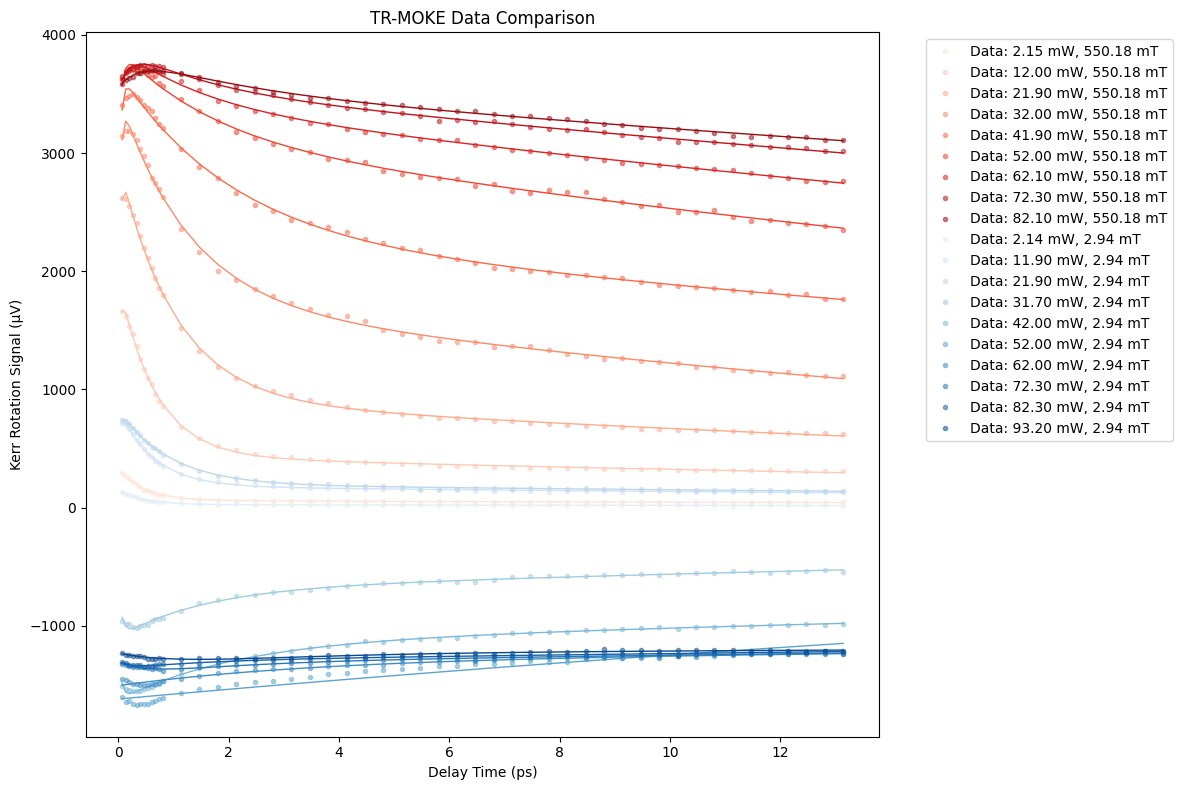

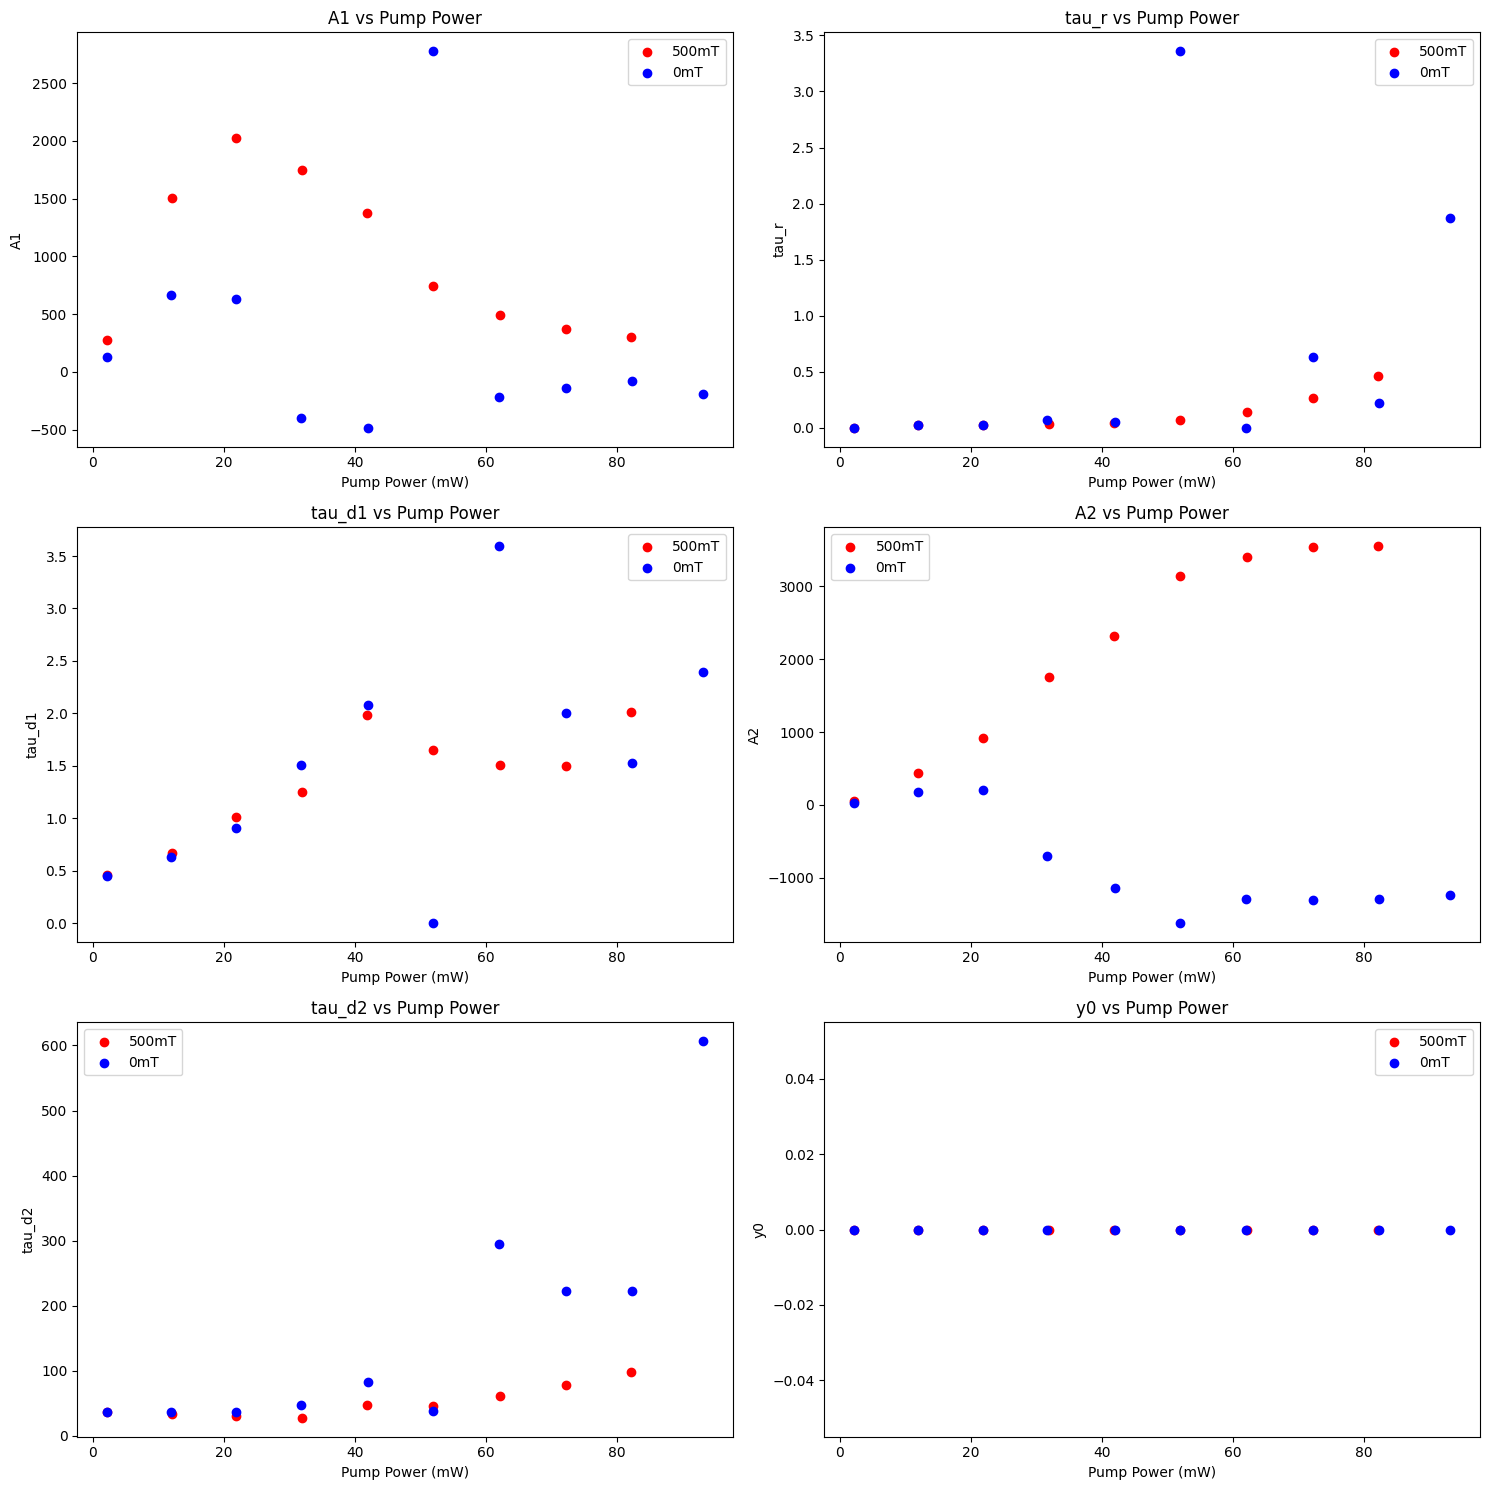

Text(0.5, 1.0, 'Al/SiO2 sub - [CoPt]x1')

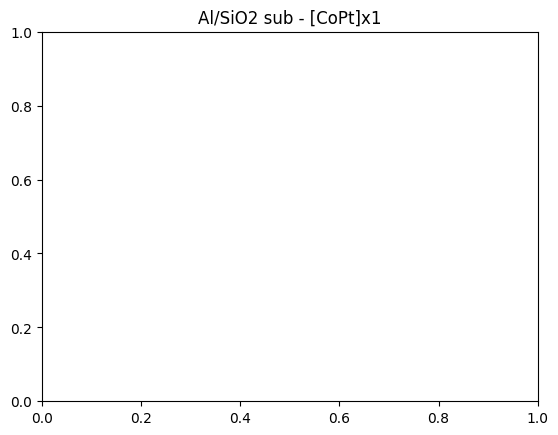

In [72]:
import trmoke
from importlib import reload
reload(trmoke)
folder_al_1x_0mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-0mT-Powersweep'
folder_al_1x_500mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Al-CoPt1x-500mT-Powersweep'

analyzer = trmoke.TRMOKEAnalyzer()
analyzer.analyze_folders([folder_al_1x_500mT, folder_al_1x_0mT], ['500mT', '0mT'],['Reds', 'Blues'], double_exp=True)
plt.title('Al/SiO2 sub - [CoPt]x1')

{'Fieldstrength(mT)': -905.562575992642, 'Pumppower(mW)': 2.12, 'Addnumber': 4.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.01778, 'HWPangle(pump)': 191.71648, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -918.153780648884, 'Pumppower(mW)': 12.0, 'Addnumber': 4.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.01778, 'HWPangle(pump)': 196.12649, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -932.791627526085, 'Pumppower(mW)': 22.0, 'Addnumber': 4.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.01778, 'HWPangle(pump)': 198.40768, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -956.25055843365, 'Pumppower(mW)': 32.0, 'Addnumber': 4.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.

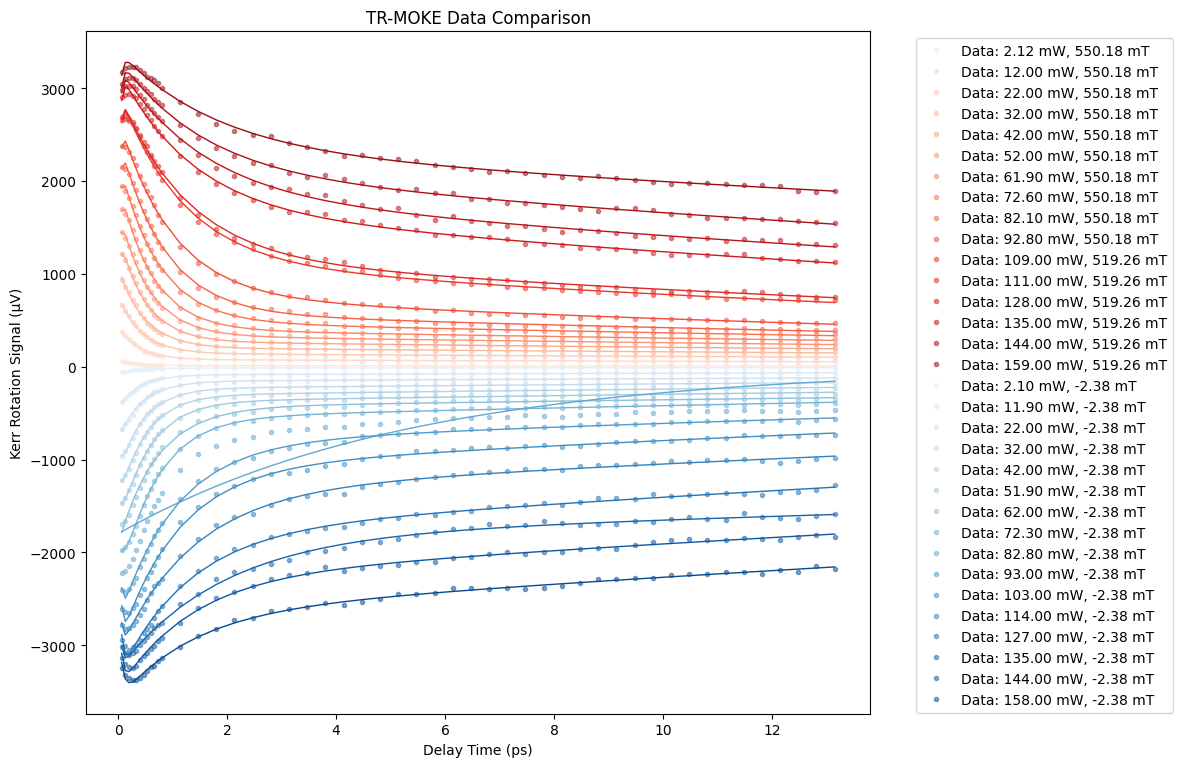

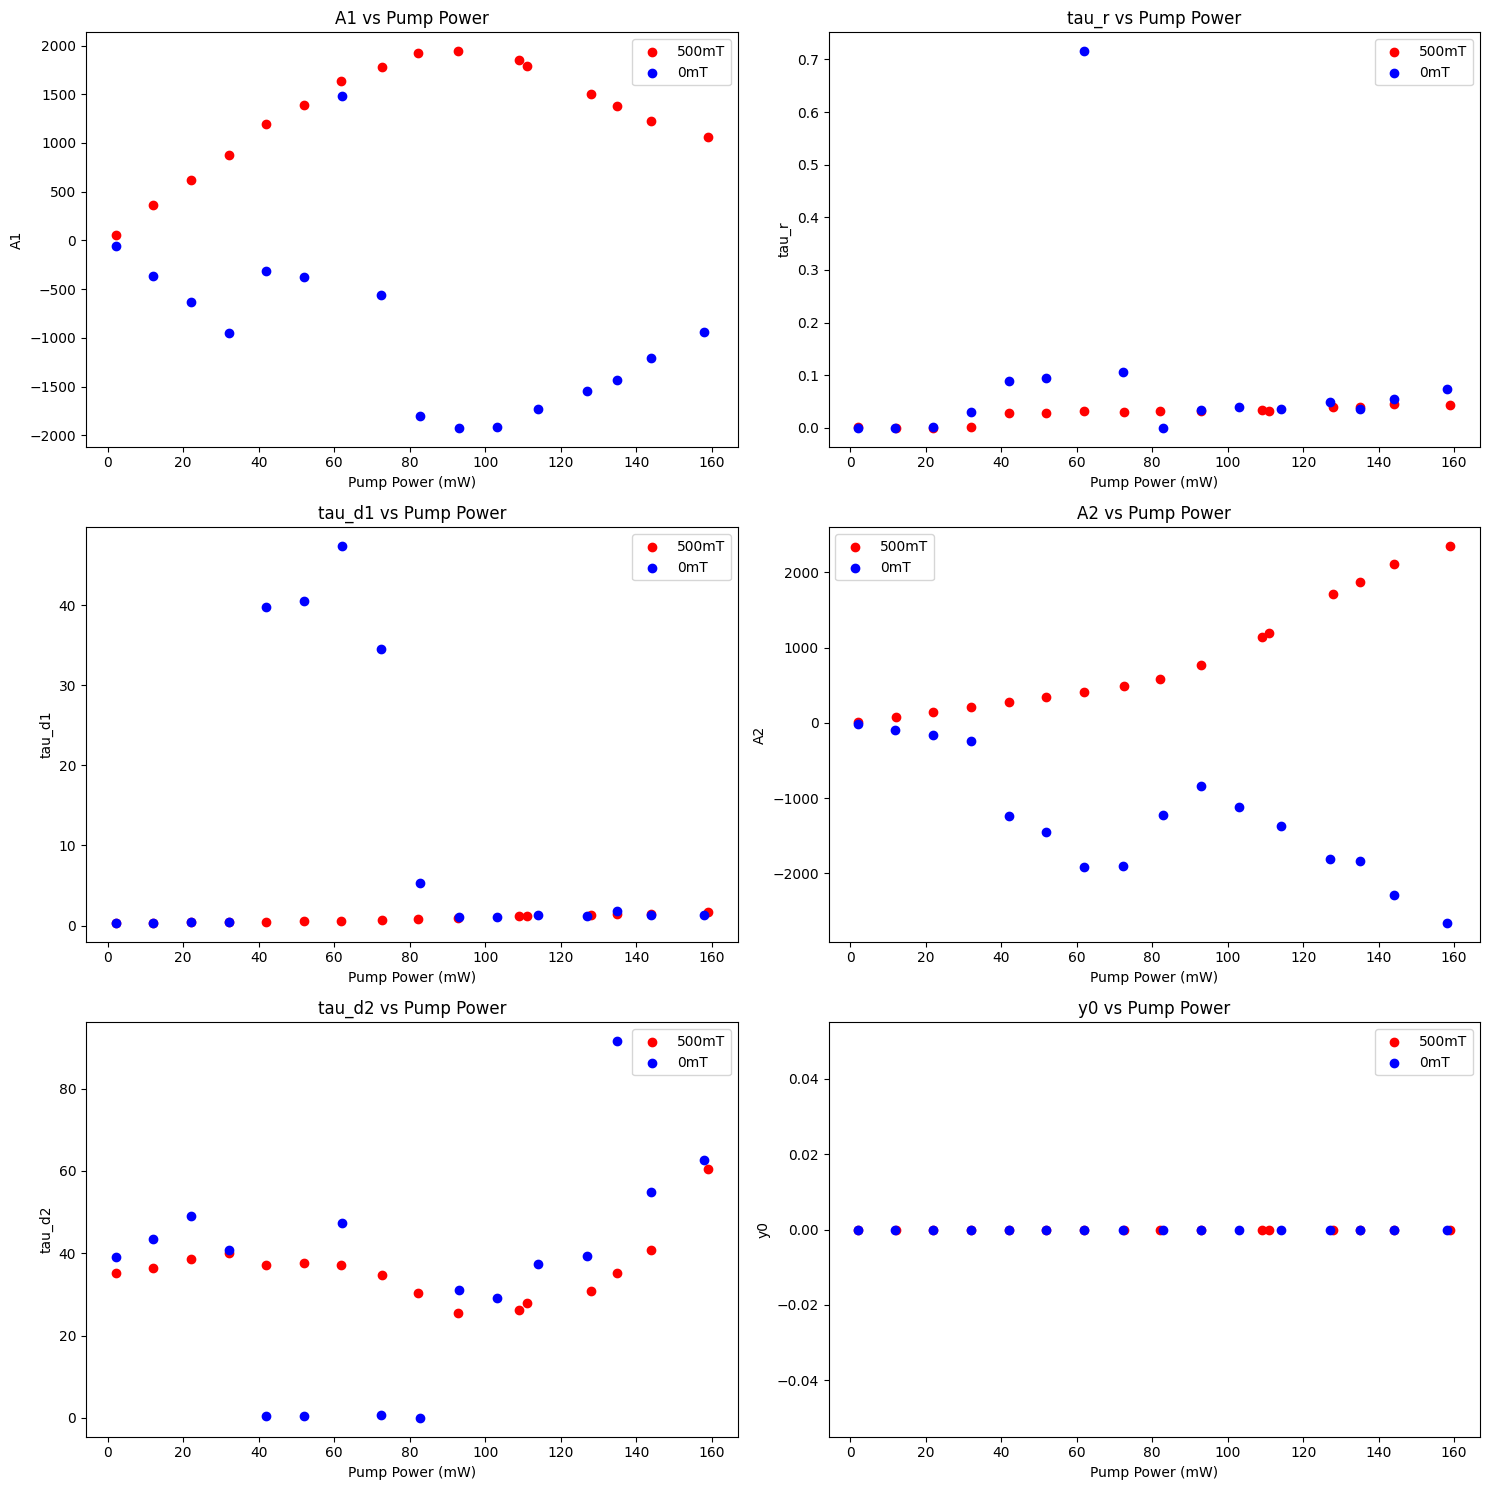

Text(0.5, 1.0, 'Si/SiO2 sub - [CoPt]x1')

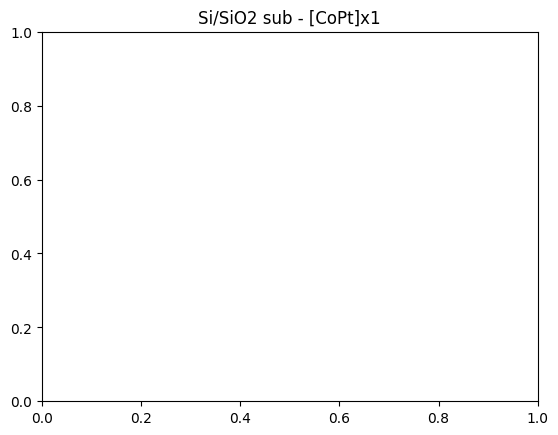

In [71]:
import trmoke
from importlib import reload
reload(trmoke)
folder_si_1x_0mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Si-CoPt1x-0mT-Powersweep'
folder_si_1x_500mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Si-CoPt1x-500mT-Powersweep'

analyzer = trmoke.TRMOKEAnalyzer()
analyzer.analyze_folders([folder_si_1x_500mT, folder_si_1x_0mT], ['500mT', '0mT'],['Reds', 'Blues'], double_exp=True)
plt.title('Si/SiO2 sub - [CoPt]x1')

{'Fieldstrength(mT)': -1219.64419856977, 'Pumppower(mW)': 2.15, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 191.67718, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1218.46101829531, 'Pumppower(mW)': 12.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 196.18323, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1217.69200162182, 'Pumppower(mW)': 21.9, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 198.46554, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1216.92302465821, 'Pumppower(mW)': 32.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1

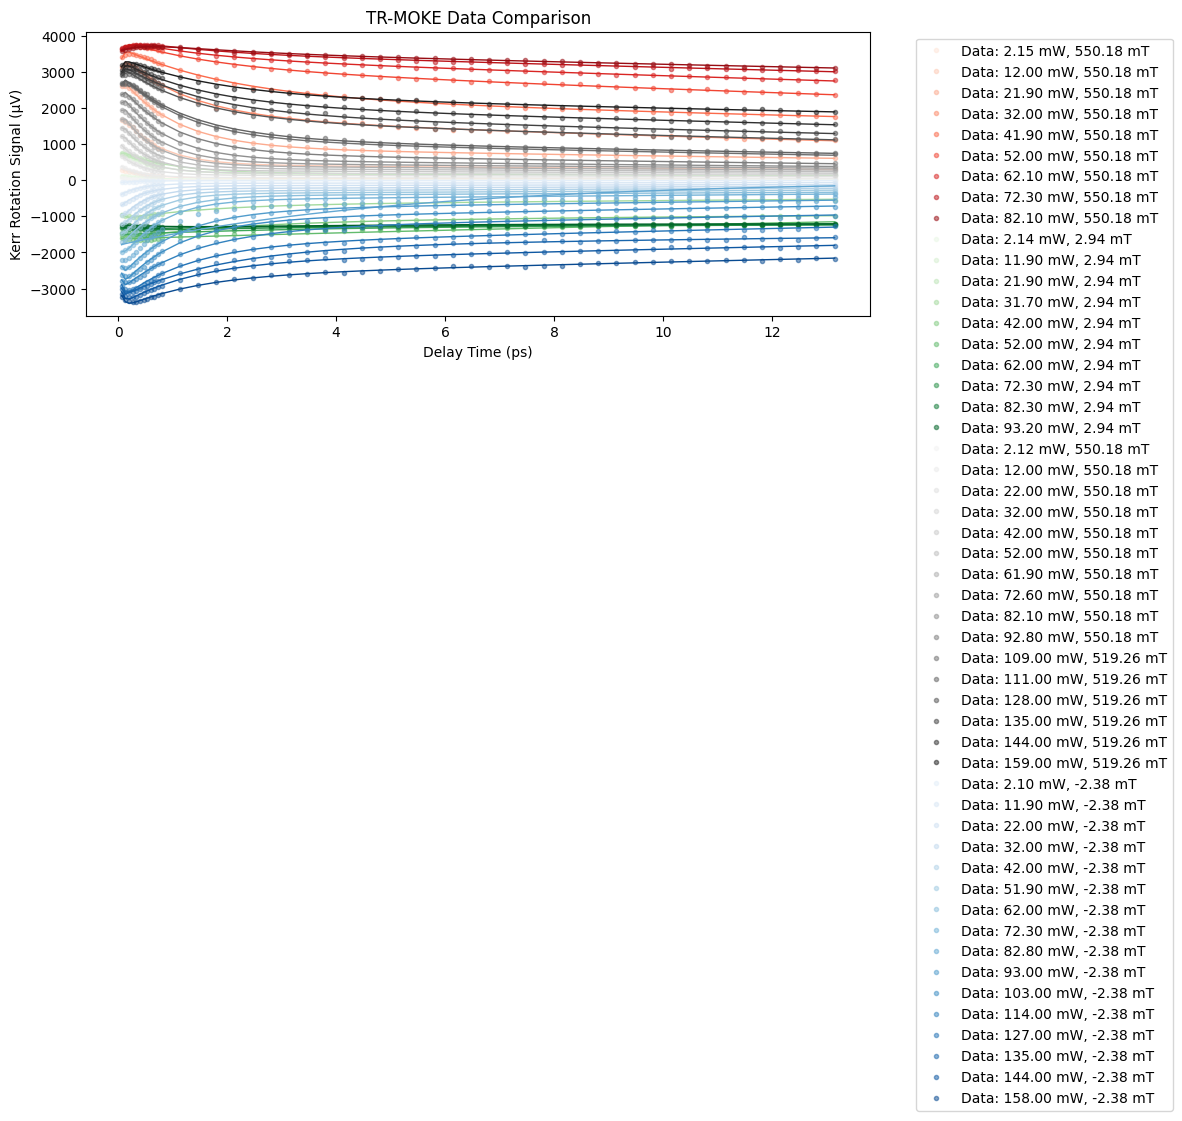

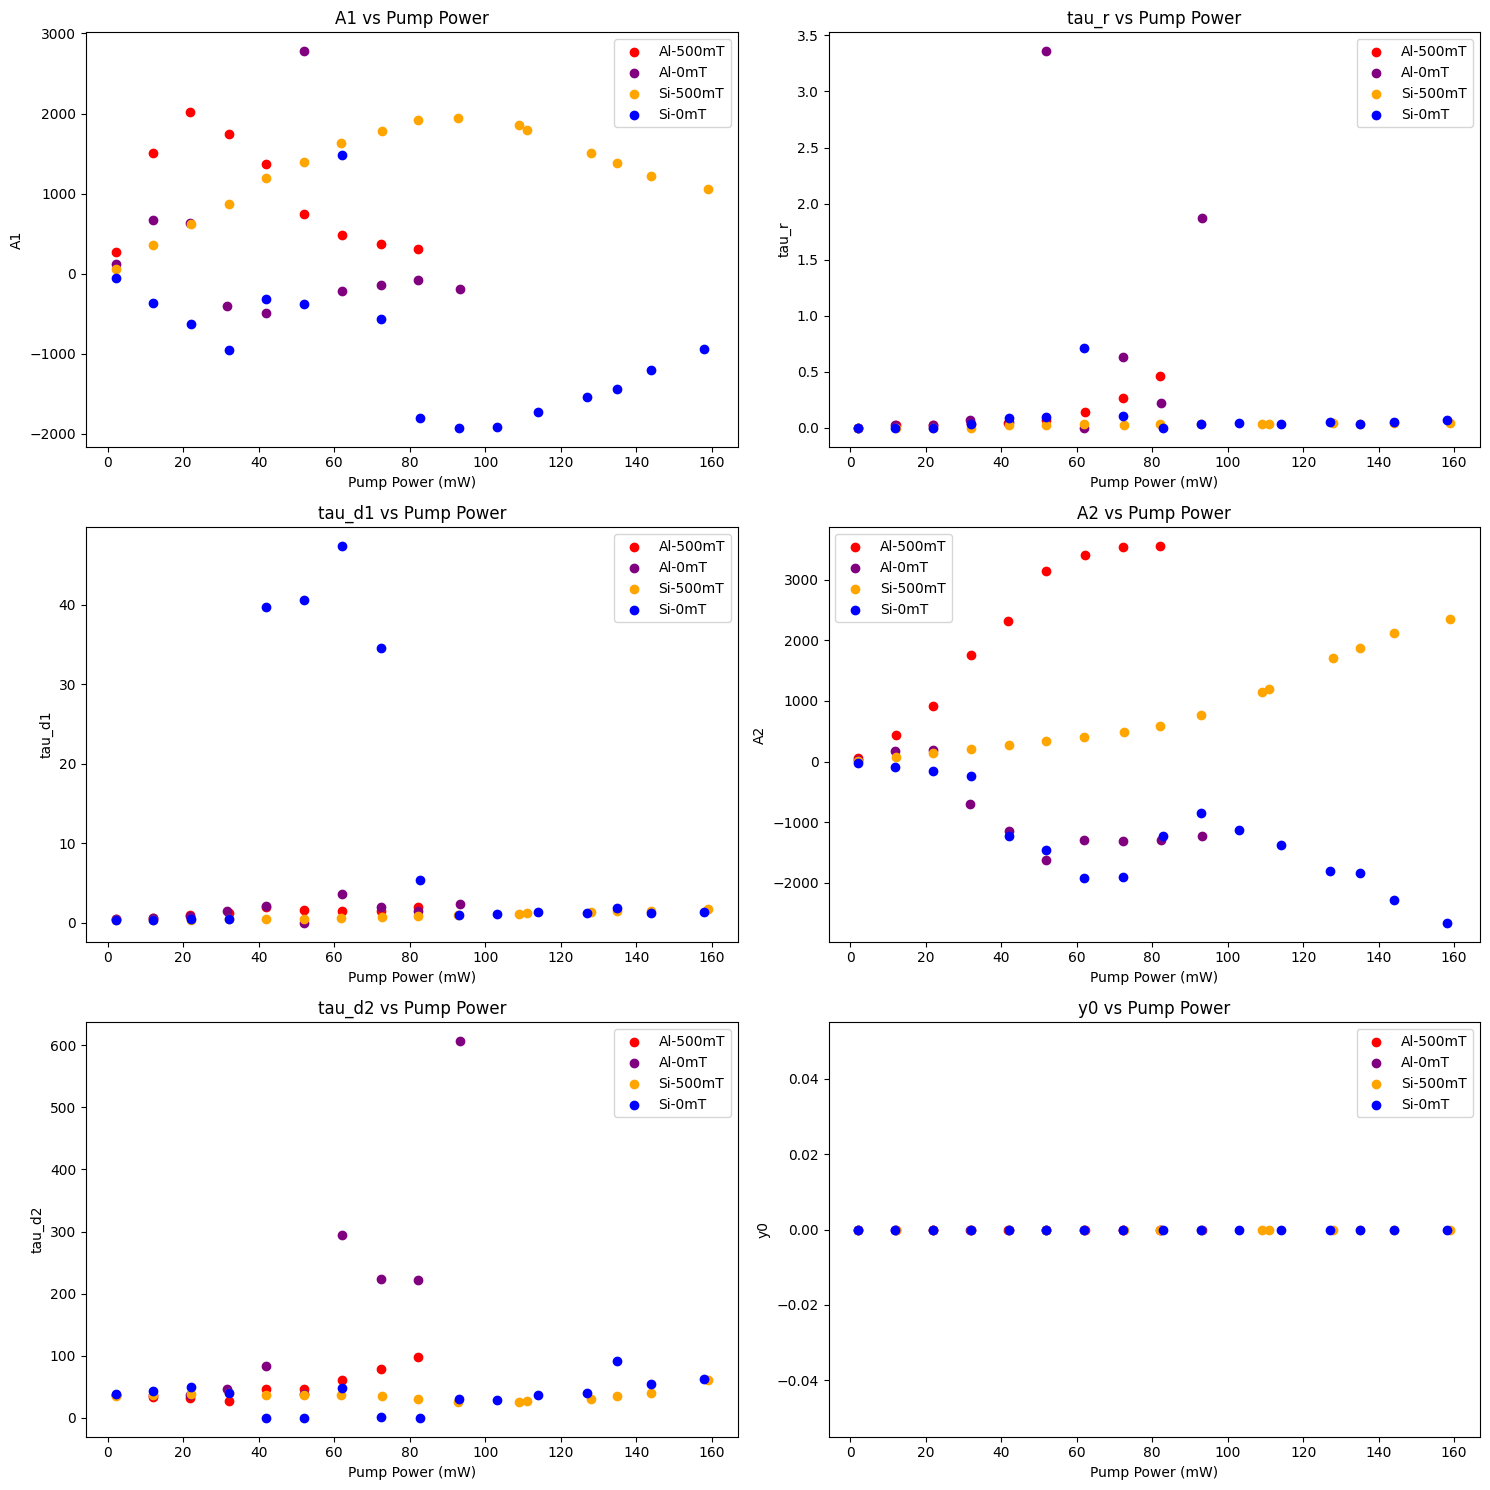

{'Fieldstrength(mT)': -1219.64419856977, 'Pumppower(mW)': 2.15, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 191.67718, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1218.46101829531, 'Pumppower(mW)': 12.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 196.18323, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1217.69200162182, 'Pumppower(mW)': 21.9, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 198.46554, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1216.92302465821, 'Pumppower(mW)': 32.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1

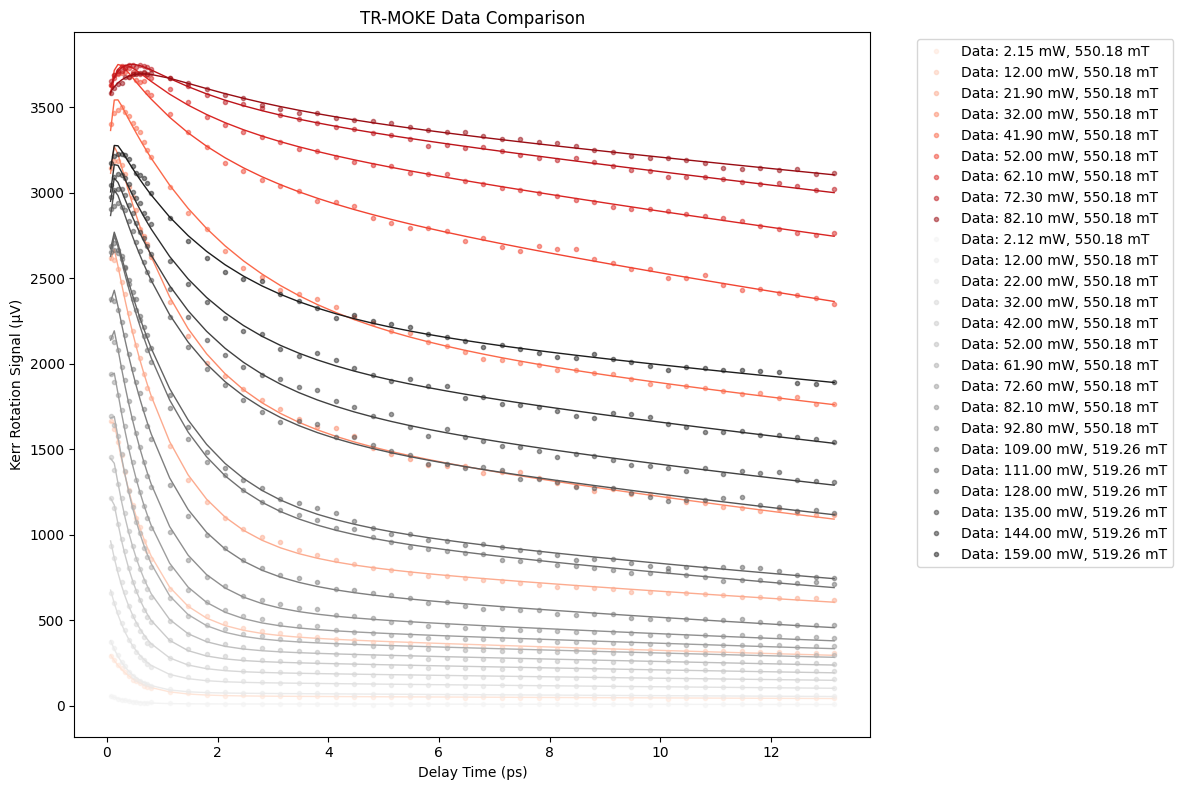

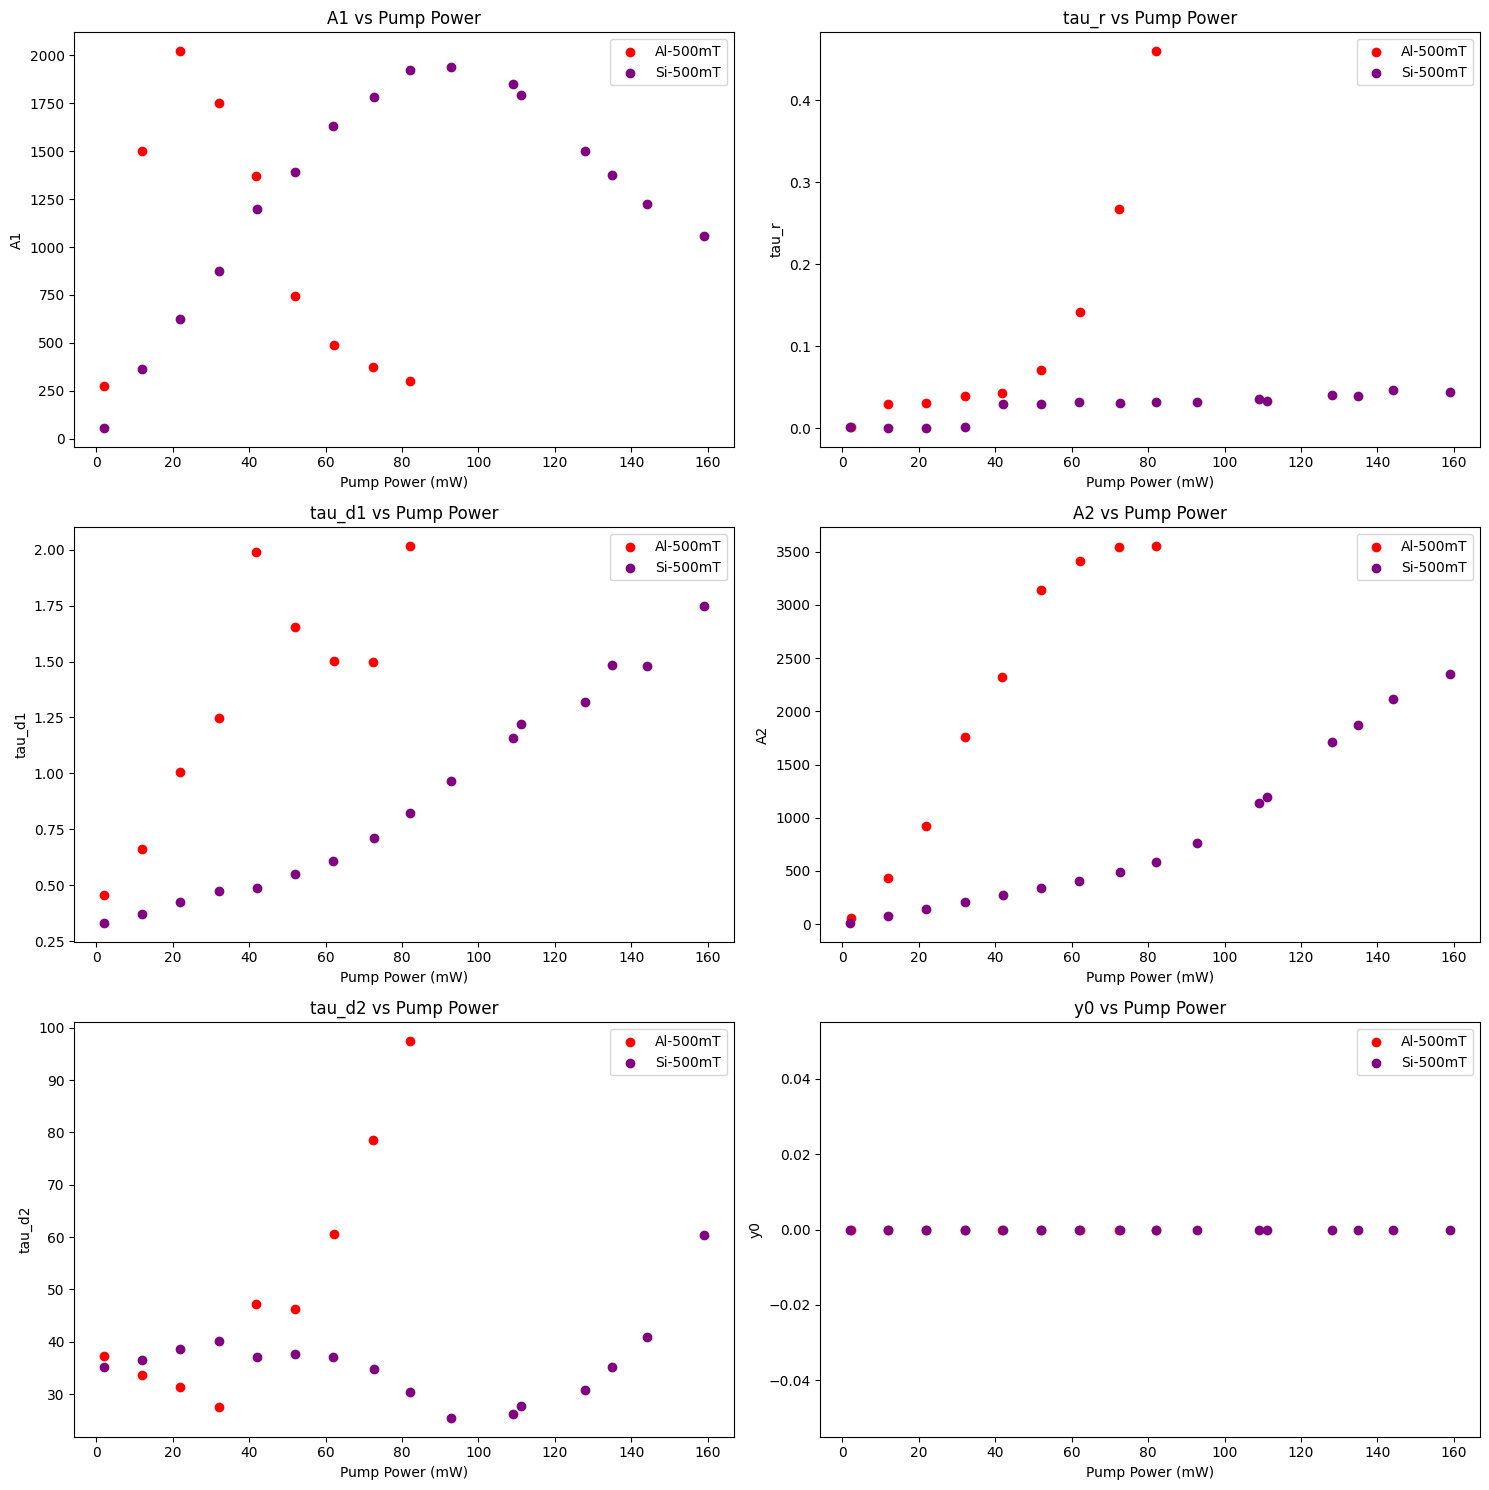

{'Fieldstrength(mT)': -1424.84851808198, 'Pumppower(mW)': 2.14, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': -20.0, 'Expectedfield(mT)': 2.94230534759994, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 191.67893, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1424.90870003614, 'Pumppower(mW)': 11.9, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': -20.0, 'Expectedfield(mT)': 2.94230534759994, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 196.16801, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1424.54761376079, 'Pumppower(mW)': 21.9, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': -20.0, 'Expectedfield(mT)': 2.94230534759994, 'HWPangle(probe)': 1.12978, 'HWPangle(pump)': 198.456914, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1424.54761376079, 'Pumppower(mW)': 31.7, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': -20.0, 'Expectedfield(mT)': 2.94230534759994, 'HWPangle(probe)': 

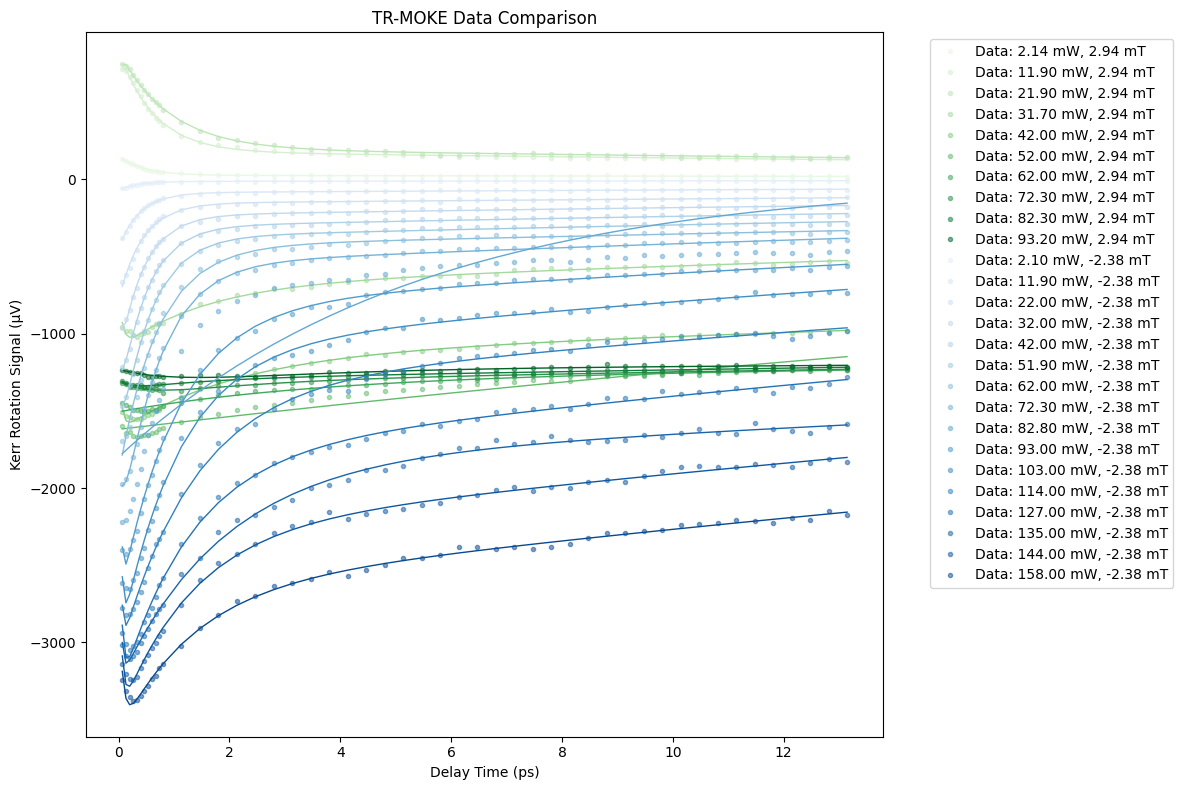

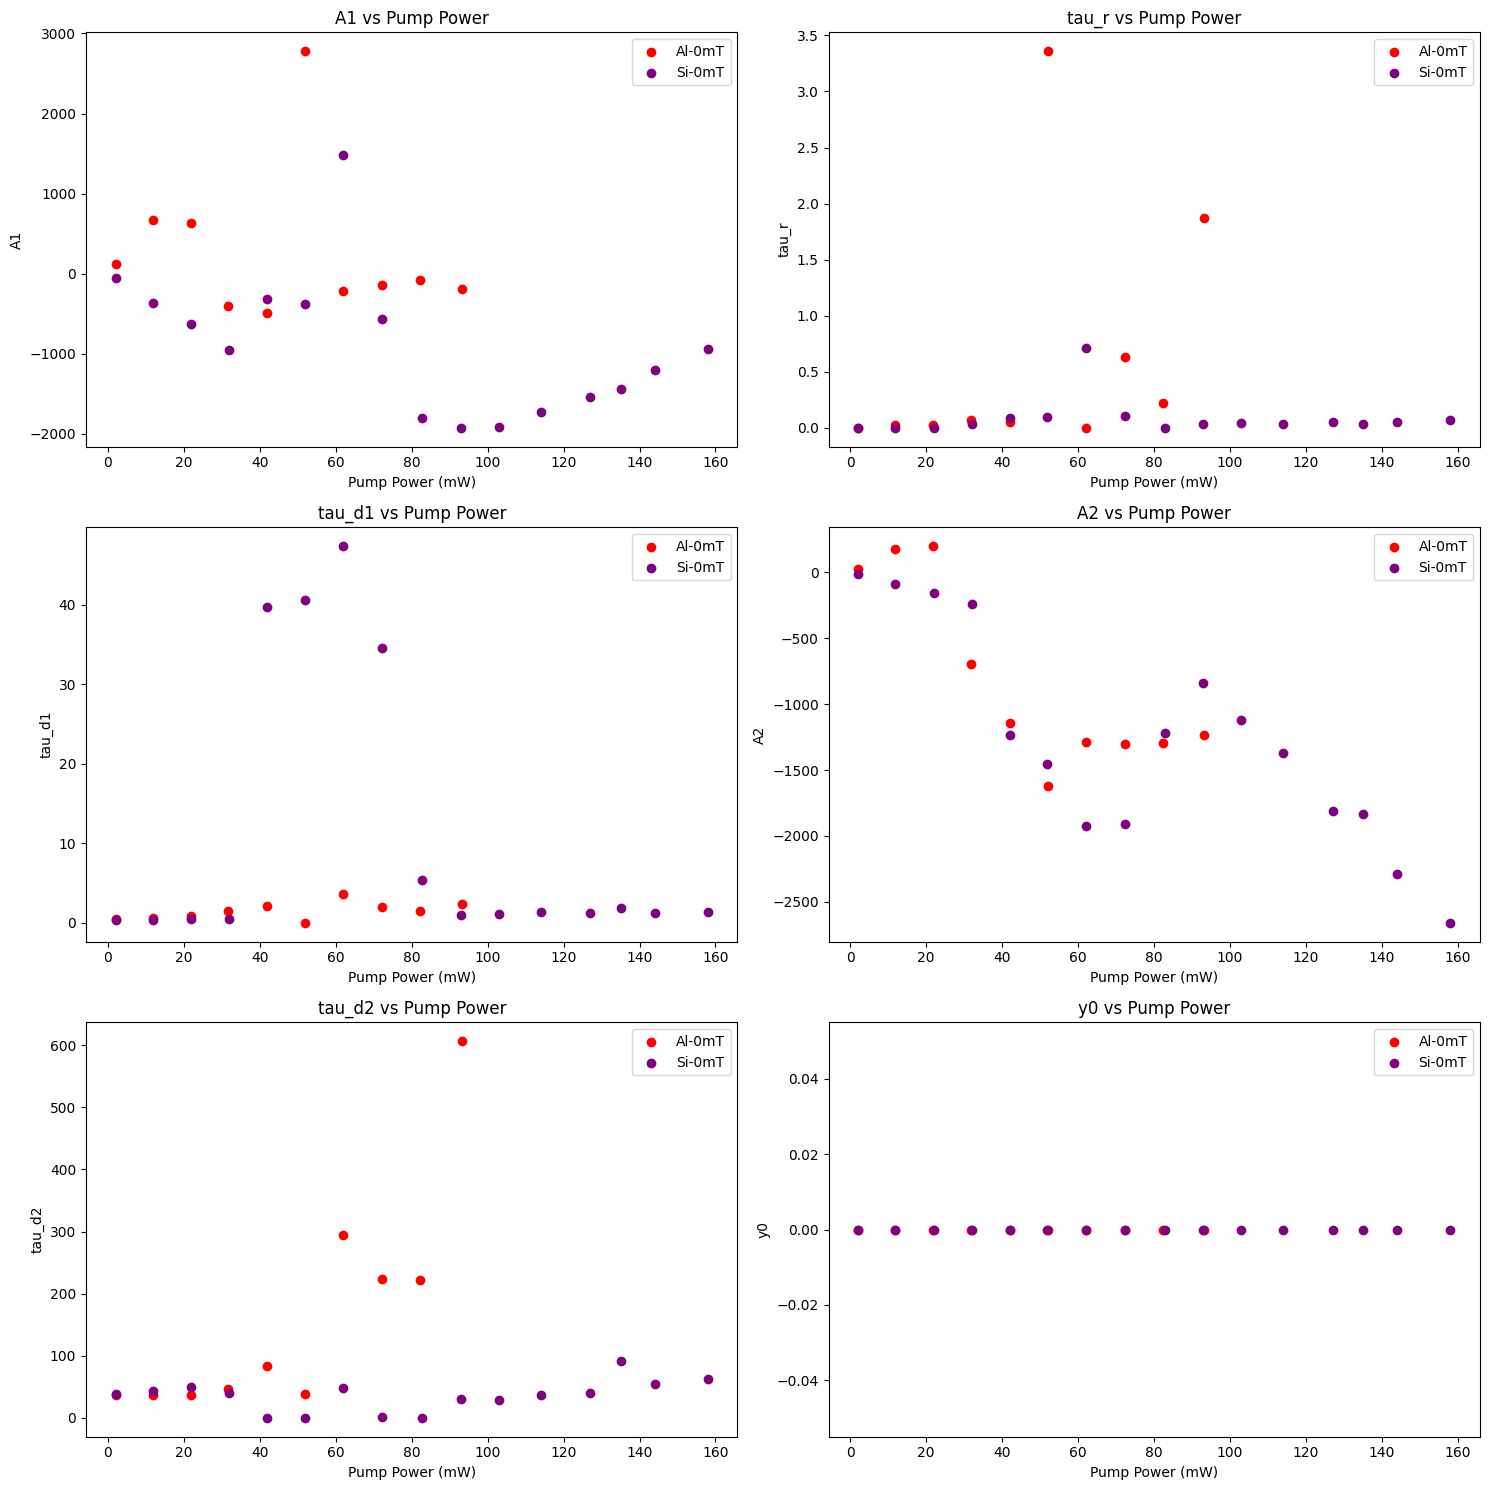

In [75]:
import trmoke
from importlib import reload
reload(trmoke)
folder_si_1x_0mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Si-CoPt1x-0mT-Powersweep'
folder_si_1x_500mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1022\Si-CoPt1x-500mT-Powersweep'

analyzer = trmoke.TRMOKEAnalyzer()
analyzer.analyze_folders([folder_al_1x_500mT, folder_al_1x_0mT,folder_si_1x_500mT, folder_si_1x_0mT], ['Al-500mT', 'Al-0mT','Si-500mT', 'Si-0mT'],['Reds','Greens','Greys', 'Blues'], double_exp=True)
# plt.title('Si/SiO2 sub - [CoPt]x1')
analyzer.analyze_folders([folder_al_1x_500mT, folder_si_1x_500mT], ['Al-500mT', 'Si-500mT'],['Reds','Greys'], double_exp=True)
analyzer.analyze_folders([folder_al_1x_0mT, folder_si_1x_0mT], ['Al-0mT', 'Si-0mT'],['Greens', 'Blues'], double_exp=True)



{'Fieldstrength(mT)': -448.30719411795, 'Pumppower(mW)': 2.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.09979, 'HWPangle(pump)': 191.536875, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1261.47283349673, 'Pumppower(mW)': 2.09, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.09979, 'HWPangle(pump)': 191.67349, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}


c:\Users\jc2713\OneDrive - Imperial College London\Documents\GitHub\SendaiLab\TRMOKE\trmoke.py:69: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return sol[:, 0]  # Return electron temperature


{'Fieldstrength(mT)': -483.428535428139, 'Pumppower(mW)': 11.9, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.09979, 'HWPangle(pump)': 196.104946, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -1269.36683478702, 'Pumppower(mW)': 20.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.09979, 'HWPangle(pump)': 17.663584, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -514.969862457204, 'Pumppower(mW)': 22.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1.09979, 'HWPangle(pump)': 198.36607, 'QWPangle(pump)': 0.0, 'reflectance': 0.0}
{'Fieldstrength(mT)': -615.55560203836, 'Pumppower(mW)': 32.0, 'Addnumber': 1.0, 'Originalstageposition': 24.0, 'FieldID': 500.0, 'Expectedfield(mT)': 550.179555664775, 'HWPangle(probe)': 1

c:\Users\jc2713\OneDrive - Imperial College London\Documents\GitHub\SendaiLab\TRMOKE\trmoke.py:189: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.show()


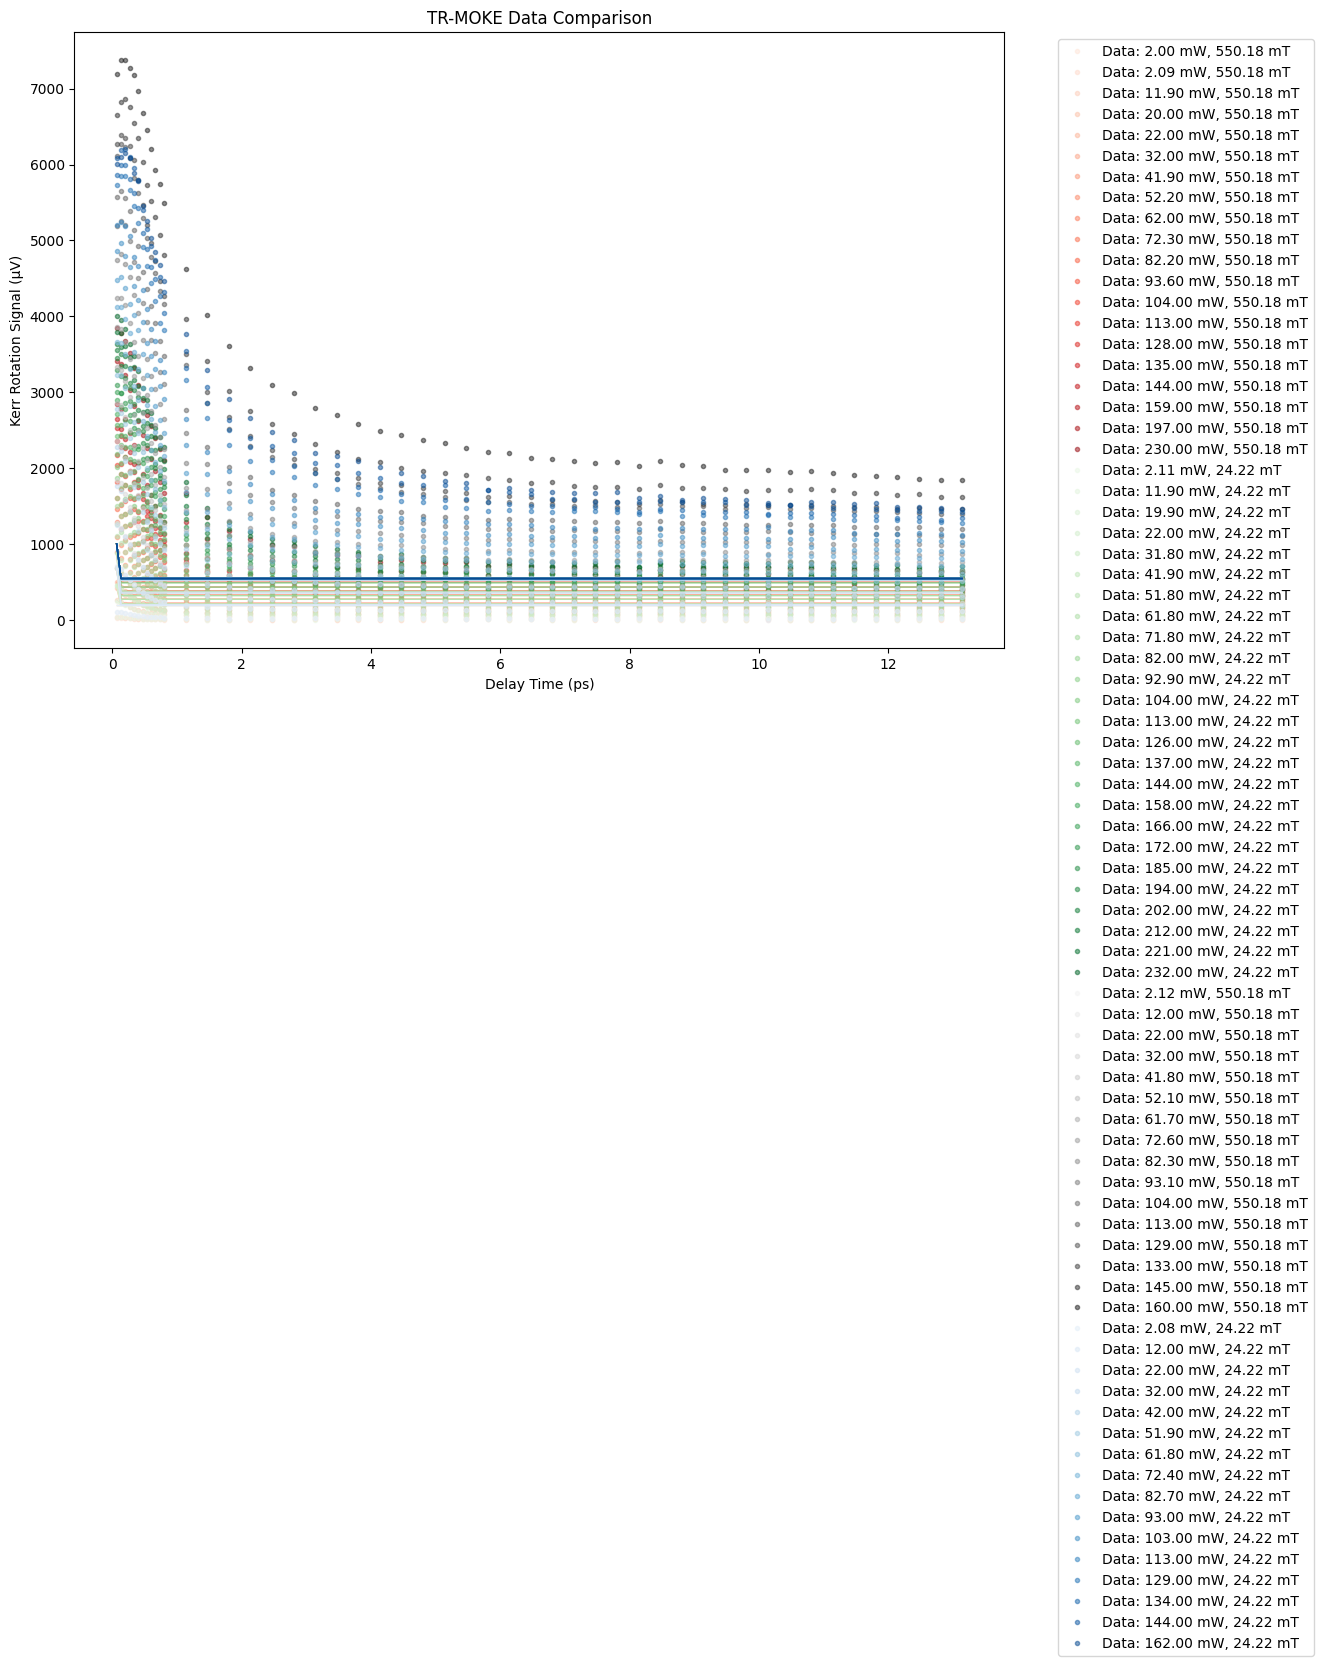

TypeError: TRMOKEAnalyzer.plot_fit_summary() got an unexpected keyword argument 'use_2tm'

In [80]:
import trmoke
from importlib import reload
reload(trmoke)
folder_al_5x_0mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-0mT-Powersweep'
folder_al_5x_500mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Si-500mT-Powersweep'#Si-500mT-Powersweep
folder_si_5x_0mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-6mT-Powersweep'
folder_si_5x_500mT = r'C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\Al-500mT-Powersweep'


analyzer = trmoke.TRMOKEAnalyzer()
analyzer.analyze_folders([folder_al_5x_500mT, folder_al_5x_0mT,folder_si_5x_500mT, folder_si_5x_0mT], ['Al-500mT', 'Al-0mT','Si-500mT', 'Si-0mT'],['Reds','Greens','Greys', 'Blues'], double_exp=False,use_2tm=True)
# plt.title('Si/SiO2 sub - [CoPt]x1')
analyzer.analyze_folders([folder_al_5x_500mT, folder_si_5x_500mT], ['Al-500mT', 'Si-500mT'],['Reds','Greys'], double_exp=False,use_2tm=True)
analyzer.analyze_folders([folder_al_5x_0mT, folder_si_5x_0mT], ['Al-0mT', 'Si-0mT'],['Greens', 'Blues'], double_exp=False,use_2tm=True)



C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_2.12mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_12.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_21.9mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_32.0mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_41.8mW_509.mT_0deg.txt
C:\Users\jc2713\OneDrive - Imperial College London (1)\Tohoku - pump priming\Data\TRMOKE\1021\500mT-Powersweep\av-91024-CoPtx5-Alsub-Remount_51.9mW_509.mT_0deg.txt
C:\Users\jc2713\

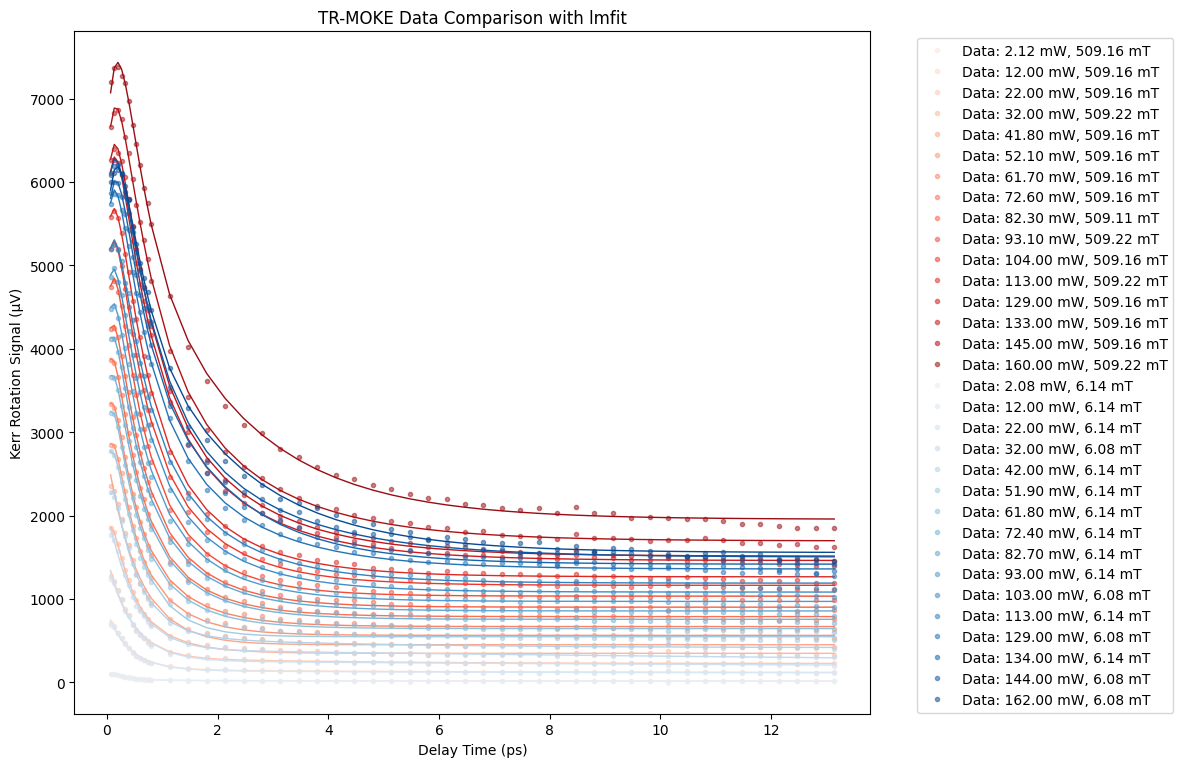

TypeError: 'NoneType' object is not iterable

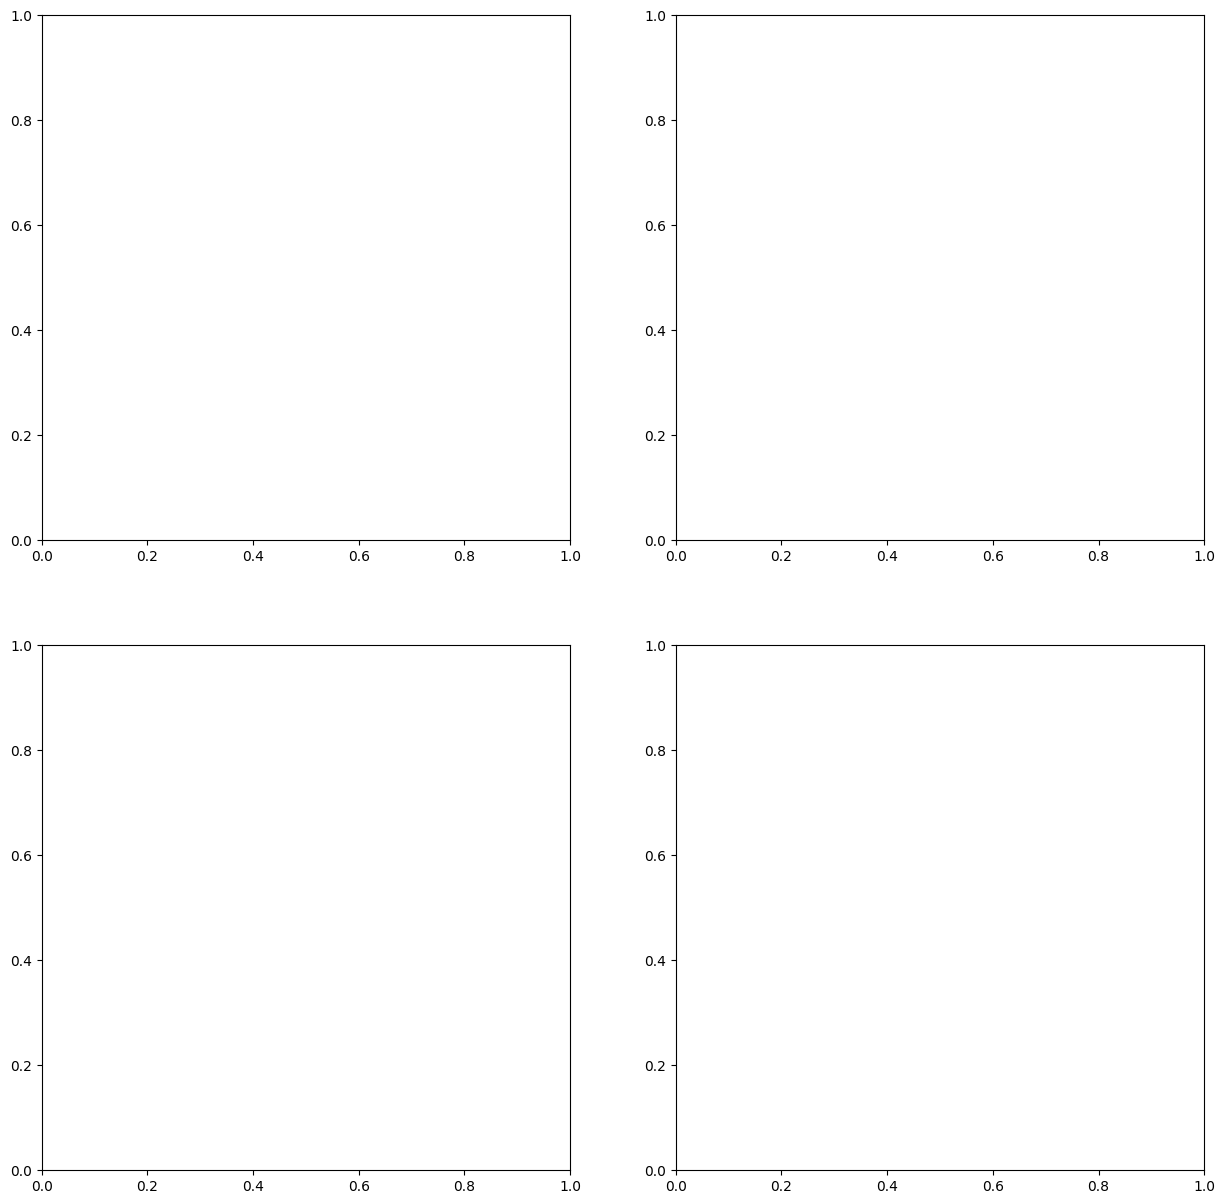

In [62]:

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fit_results1 = process_folder_double(folder1, Reds, ax)
fit_results2 = process_folder_double(folder2, Blues, ax)

ax.set_xlabel('Delay Time (ps)')
ax.set_ylabel('Kerr Rotation Signal (μV)')
ax.set_title('TR-MOKE Data Comparison with lmfit')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot summary of fit parameters
plot_fit_summary_double(fit_results = [fit_results1, fit_results2], labels = ['500mT', '6mT'])